# Final Project: Stroke Prediction Analysis
### Aidan Sullivan
## Overview



Dataset is a sample population of patient data with a binary variable for strokes and is available through Kaggle (https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). The following project will go trhough the data science process in attempt to train classification models to predict whether or not a patient will/is occuring a stroke based on individual variables. The data will be loaded in dataframes, cleaned as appropriate, and then explored through exploratory data analysis with visualizations to gain an understanding of the sample population. We will start with various logisitic regression models, refine those models as seen fit to attempt to improve the accuracy. Then we will create a decision tree and random forest model, followed up by a Bernoulli Naive Bayes model, and then a Support Vector Machine model (linear, radial basis function, and polynomial). 



## Data Load & Cleaning


In [1]:
#pip install imbalanced-learn

In [54]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as pt
import seaborn as sb
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, auc,roc_curve
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
def get_data(file):
    try:
        df = pd.read_csv(file)
        df_head = df.head(1).to_string()
        print("Head of Dataframe:")
        print(df_head)

        print("\nSummary Statistics:")
        print(df.describe())

        return df
              
    except FileNotFoundError:
        print("File not found, check file path, then check for file")
    except Exception as e:
        print("An error occurred:", e)

In [4]:
stroke = get_data(r"C:\Users\14108\OneDrive\Documents\healthcare-dataset-stroke-data.csv")

Head of Dataframe:
     id gender   age  hypertension  heart_disease ever_married work_type Residence_type  avg_glucose_level   bmi   smoking_status  stroke
0  9046   Male  67.0             0              1          Yes   Private          Urban             228.69  36.6  formerly smoked       1

Summary Statistics:
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.0

In [5]:
# Maintain the original dataset and load to a dataset for wrangling 
df = stroke

# Check for missing values prior to data cleaning 
missing = df.columns[df.isna().any()].tolist()
records = len(df)

print('Missing Values Check')
for col in missing: 
    missing_count = df[col].isna().sum()
    missing_percent = (missing_count / records) * 100
    print(f'{col}: {missing_count} missing values ({missing_percent:.2f}%)')

Missing Values Check
bmi: 201 missing values (3.93%)


In [6]:
# Clean Data 
# Remove any spaces in the columns
df.rename(columns = lambda x: x.replace(' ', ''), inplace = True)

# Convert headers to lowercase 
df.columns = df.columns.str.lower()

# Convert all values to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# From missing values less than 4% of the overall data, missing records will be removed 
df.dropna(inplace = True)

# Convert categorical variables to dummy variables 
df = pd.get_dummies(df, columns = ['gender','ever_married','work_type','residence_type','smoking_status'])

# Columns to drop
df.drop(columns = ['id'], inplace = True)

df.head()

age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0  67.0             0              1             228.69  36.6       1   
2  80.0             0              1             105.92  32.5       1   
3  49.0             0              0             171.23  34.4       1   
4  79.0             1              0             174.12  24.0       1   
5  81.0             0              0             186.21  29.0       1   

   gender_female  gender_male  gender_other  ever_married_no  \
0              0            1             0                0   
2              0            1             0                0   
3              1            0             0                0   
4              1            0             0                0   
5              0            1             0                0   

   ever_married_yes  work_type_children  work_type_govt_job  \
0                 1                   0                   0   
2                 1                   0                   0   
3                 1                   0                   0   
4                 1                   0                   0   
5                 1                   0                   0   

   work_type_never_worked  work_type_private  work_type_self-employed  \
0                       0                  1                        0   
2                       0                  1                        0   
3                       0                  1                        0   
4                       0                  0                        1   
5                       0                  1                        0   

   residence_type_rural  residence_type_urban  smoking_status_formerly smoked  \
0                     0                     1                               1   
2                     1                     0                               0   
3                     0                     1                               0   
4                     1                     0                               0   
5                     0                     1                               1   

   smoking_status_never smoked  smoking_status_smokes  smoking_status_unknown  
0                            0                      0                       0  
2                            1                      0                       0  
3                            0                      1                       0  
4                            1                      0                       0  
5                            0                      0                       0

## Exploratory Data Analysis
### Summary Statisics & Visualizations

               age  hypertension          bmi       stroke  gender_female  \
count  4909.000000   4909.000000  4909.000000  4909.000000    4909.000000   
mean     42.865374      0.091872    28.893237     0.042575       0.590141   
std      22.555115      0.288875     7.854067     0.201917       0.491858   
min       0.080000      0.000000    10.300000     0.000000       0.000000   
25%      25.000000      0.000000    23.500000     0.000000       0.000000   
50%      44.000000      0.000000    28.100000     0.000000       1.000000   
75%      60.000000      0.000000    33.100000     0.000000       1.000000   
max      82.000000      1.000000    97.600000     1.000000       1.000000   

       gender_male  gender_other  
count  4909.000000   4909.000000  
mean      0.409656      0.000204  
std       0.491820      0.014273  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       1.000000      0.000000  
max       1.000000      1.

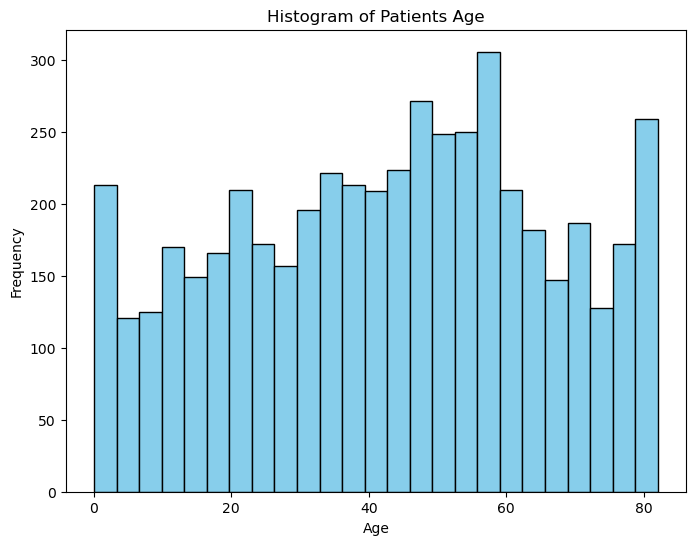

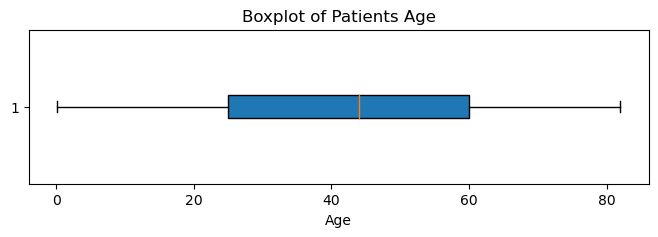

Number of stroke patients: 209
Percentage of stroke patients in sample population: 4.26%


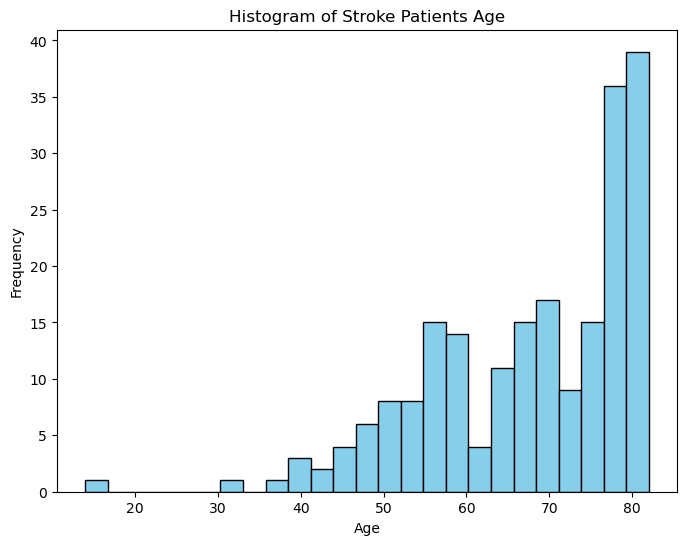

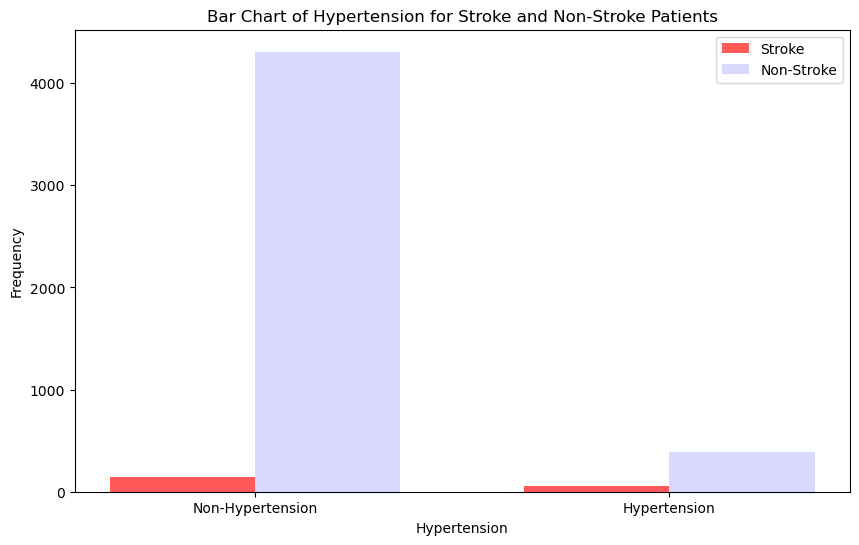

Percentage of hypertension among stroke patients: 28.71%
Percentage of hypertension among non-stroke patients: 8.32%


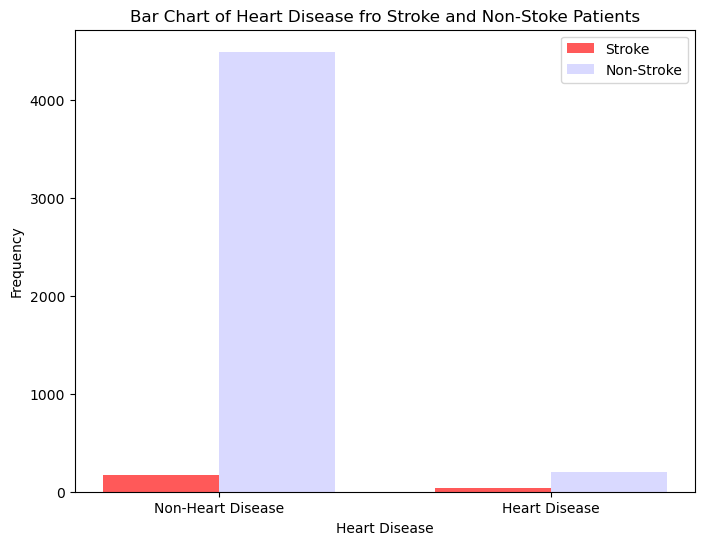

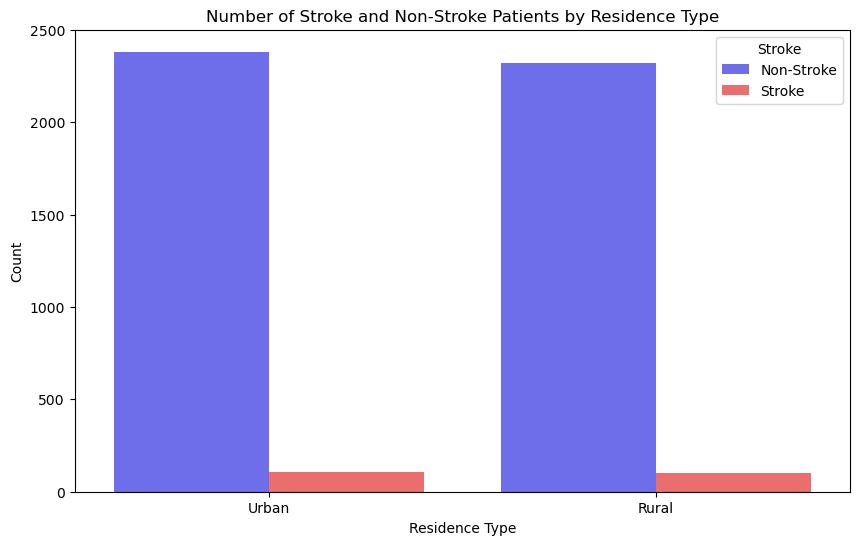

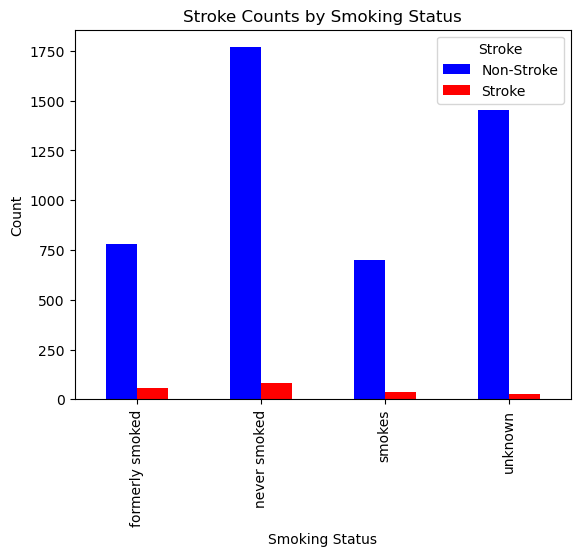

    smoking_status  non_stroke  stroke
0  formerly smoked         780      57
1     never smoked        1768      84
2           smokes         698      39
3          unknown        1454      29


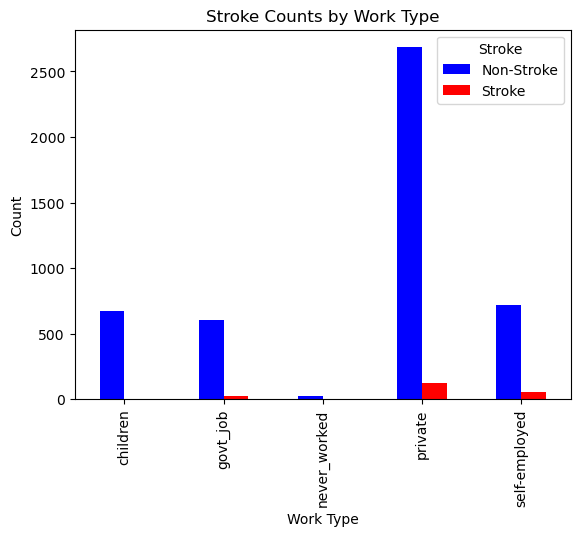

    working_type  non_stroke  stroke
0       children         670       1
1       govt_job         602      28
2   never_worked          22       0
3        private        2684     127
4  self-employed         722      53


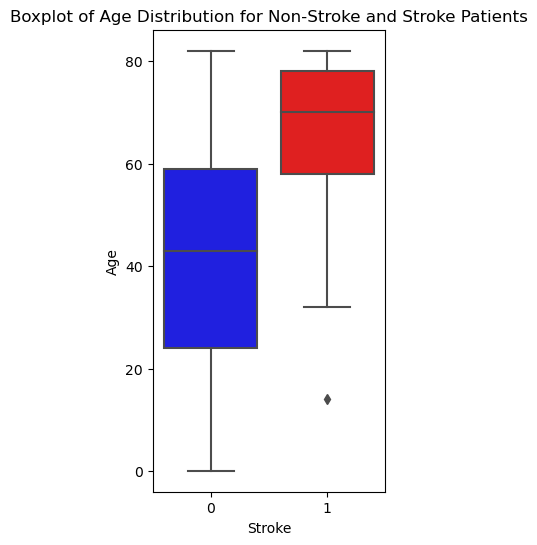

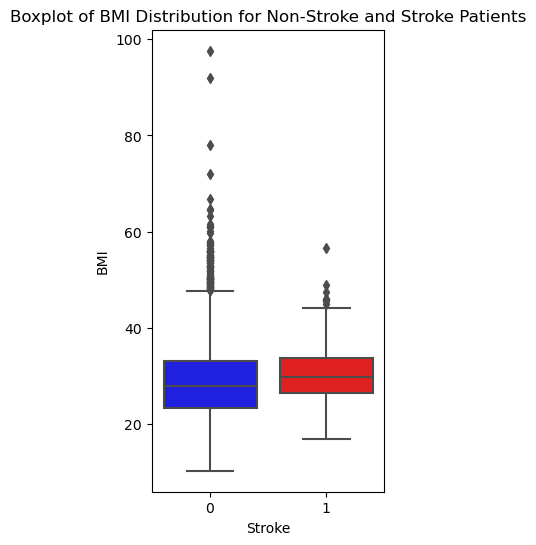

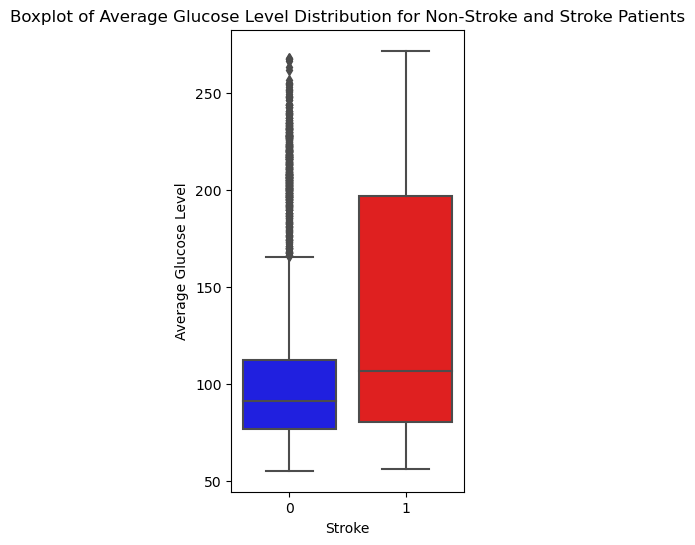

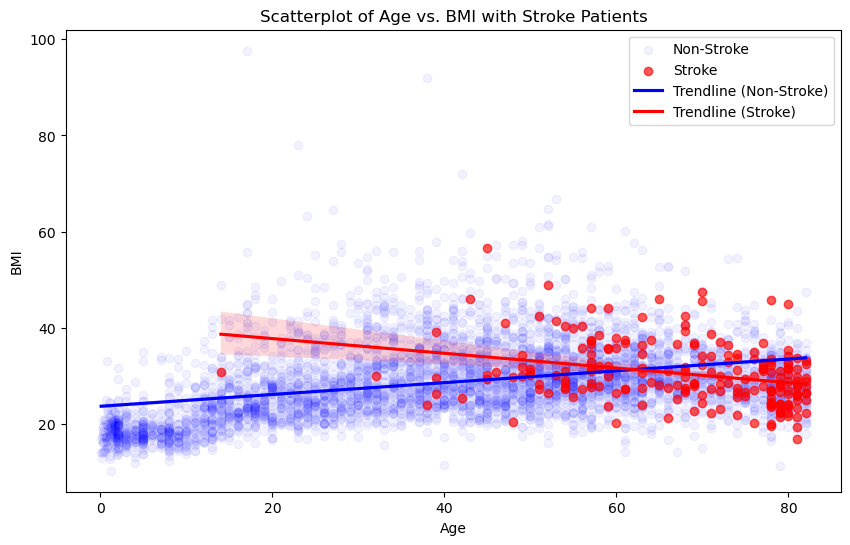

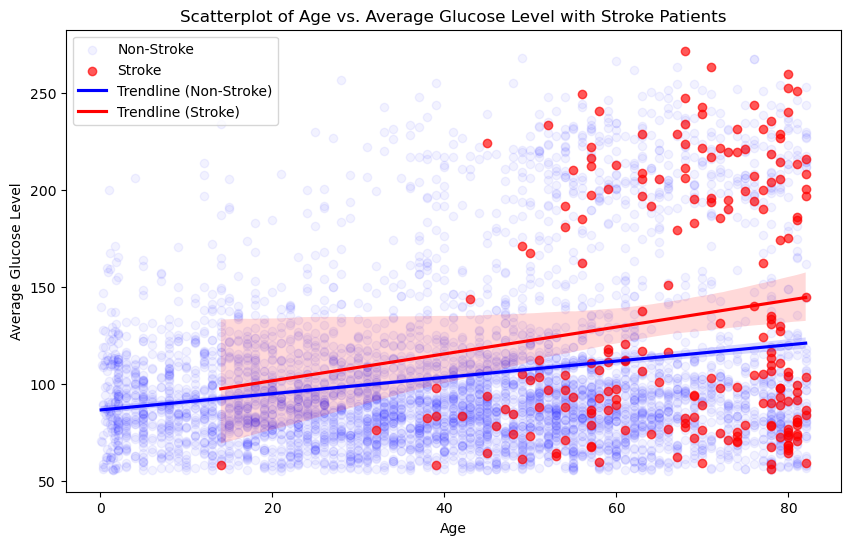

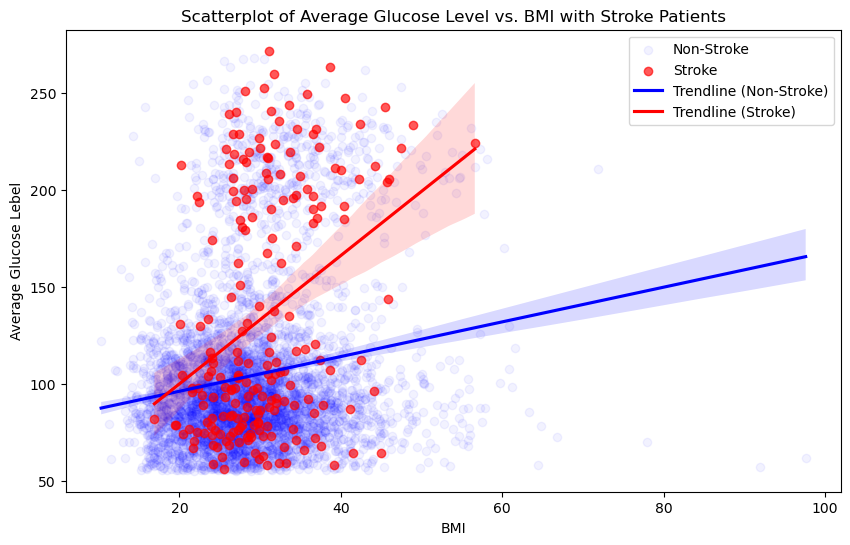

In [44]:
# Summary Statistics 
stat_limit = ['age','hypertension','bmi','stroke','gender_female','gender_male','gender_other']
print(df[stat_limit].describe())

# Age histogram 
pt.figure(figsize = (8,6))
pt.hist(df['age'], bins = 25, edgecolor = 'black', color = 'skyblue')
pt.title('Histogram of Patients Age')
pt.xlabel('Age')
pt.ylabel('Frequency')
pt.show()

# Age Boxplot 
pt.figure(figsize = (8,2))
pt.boxplot(df['age'], vert = False, patch_artist = True)
pt.title('Boxplot of Patients Age')
pt.xlabel('Age')
pt.show()


# Stroke versus Non-Stroke dataframes for visualizations
stroke_patients = df[df['stroke'] == 1]
non_stroke_patients = df[df['stroke'] == 0]

# Number of Stroke Patients
stroke_count = len(stroke_patients)
# Calculate percentage of population
percent_stroke = (stroke_count / len(df)) * 100

print('Number of stroke patients:', stroke_count)
print('Percentage of stroke patients in sample population: {:.2f}%'.format(percent_stroke))

# Histogram of Stroke Patients
pt.figure(figsize = (8,6))
pt.hist(stroke_patients['age'], bins = 25, edgecolor = 'black', color = 'skyblue')
pt.title('Histogram of Stroke Patients Age')
pt.xlabel('Age')
pt.ylabel('Frequency')
pt.show()

# Bar chart of Hypertension for Stroke and Non-Stroke Patients
pt.figure(figsize = (10,6))
stroke_hypertension_counts = stroke_patients['hypertension'].value_counts().sort_index()
non_stroke_hypertension_counts = non_stroke_patients['hypertension'].value_counts().sort_index()
bar_width = 0.35
bar_positions_stroke = range(len(stroke_hypertension_counts))
bar_positions_non_stroke = [pos + bar_width for pos in bar_positions_stroke]
pt.bar(bar_positions_stroke, stroke_hypertension_counts, width = bar_width, color = 'red', alpha = 0.65, label = 'Stroke')
pt.bar(bar_positions_non_stroke, non_stroke_hypertension_counts, width = bar_width, color = 'blue', alpha = 0.15, label = 'Non-Stroke')
pt.xlabel('Hypertension')
pt.ylabel('Frequency')
pt.title('Bar Chart of Hypertension for Stroke and Non-Stroke Patients')
pt.xticks([pos + bar_width / 2 for pos in bar_positions_stroke], ['Non-Hypertension', 'Hypertension'])
pt.legend()
pt.show()

# Bar chart of Heart Disease for Stroke and Non-Stoke patients 
pt.figure(figsize = (8,6))
stroke_hd_counts = stroke_patients['heart_disease'].value_counts().sort_index()
non_stroke_hd_counts = non_stroke_patients['heart_disease'].value_counts().sort_index()
bar_width = 0.35
bar_positions_stroke = range(len(stroke_hd_counts))
bar_positions_non_stroke = [pos + bar_width for pos in bar_positions_stroke]
pt.bar(bar_positions_stroke, stroke_hd_counts, width = bar_width, color = 'red', alpha = .65, label = 'Stroke')
pt.bar(bar_positions_non_stroke, non_stroke_hd_counts, width = bar_width, color = 'blue', alpha = 0.15, label = 'Non-Stroke')
pt.xlabel('Heart Disease')
pt.ylabel('Frequency')
pt.title('Bar Chart of Heart Disease fro Stroke and Non-Stoke Patients')
pt.xticks([pos + bar_width / 2 for pos in bar_positions_stroke], ['Non-Heart Disease', 'Heart Disease'])
pt.legend()
pt.show

# Percentage of Hypertension from Non-Stoke/Stroke populations
percent_hypertension_stroke = (stroke_patients['hypertension'].sum() / stroke_count) * 100
percent_hypertension_non_stroke = (non_stroke_patients['hypertension'].sum() / len(non_stroke_patients)) * 100
# Print the results
print(f'Percentage of hypertension among stroke patients: {percent_hypertension_stroke:.2f}%')
print(f'Percentage of hypertension among non-stroke patients: {percent_hypertension_non_stroke:.2f}%')

# Create separate data frame for certain EDA plots, maintain df for classification models 
eda_df = df.copy() 

# Map residence_type_rural and residence_type_urban to 'Rural' and 'Urban'
eda_df['residence_type'] = eda_df['residence_type_rural'].map({0: 'Urban', 1: 'Rural'})

# Create a bar chart for counts of stroke and non-stroke patients by residence type
pt.figure(figsize = (10, 6))
sb.countplot(x = 'residence_type', hue = 'stroke', data = eda_df, palette = {0: 'blue', 1: 'red'}, alpha = 0.65)
pt.title('Number of Stroke and Non-Stroke Patients by Residence Type')
pt.xlabel('Residence Type')
pt.ylabel('Count')
pt.legend(title = 'Stroke', labels = ['Non-Stroke', 'Stroke'])
pt.show()

# Create a new column 'smoking_status' by combining all smoking status columns
eda_df['smoking_status'] = eda_df[['smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'smoking_status_unknown']].idxmax(axis = 1).str.replace('smoking_status_', '')
smoking_status_counts = eda_df.groupby('smoking_status')['stroke'].value_counts().unstack().fillna(0)
smoking_status_counts.columns = ['non_stroke', 'stroke']
smoking_status_counts.reset_index(inplace = True)

# Smoking status side by side bar chart
ax = smoking_status_counts.plot(kind = 'bar', x = 'smoking_status', y = ['non_stroke', 'stroke'], color = ['blue', 'red'])
pt.xlabel('Smoking Status')
pt.ylabel('Count')
pt.title('Stroke Counts by Smoking Status')
pt.legend(title = 'Stroke', labels = ['Non-Stroke', 'Stroke'])
pt.show()
print(smoking_status_counts)

# Create new column 'working_type' 
eda_df['working_type'] = eda_df[['work_type_children', 'work_type_govt_job', 'work_type_never_worked', 'work_type_private', 'work_type_self-employed']].idxmax(axis=1).str.replace('work_type_', '')
working_type_counts = eda_df.groupby('working_type')['stroke'].value_counts().unstack().fillna(0)
working_type_counts.columns = ['non_stroke','stroke']
working_type_counts.reset_index(inplace = True)
working_type_counts[['non_stroke', 'stroke']] = working_type_counts[['non_stroke', 'stroke']].astype(int)

# Working Type side by side plots 
ax = working_type_counts.plot(kind = 'bar', x = 'working_type', y = ['non_stroke', 'stroke'], color = ['blue', 'red'])
pt.xlabel('Work Type')
pt.ylabel('Count')
pt.title('Stroke Counts by Work Type')
pt.legend(title = 'Stroke', labels = ['Non-Stroke', 'Stroke'])
pt.show()
print(working_type_counts)

# Boxplot of Age Stroke/Non-Stroke 
pt.figure(figsize = (3,6))
sb.boxplot(x = 'stroke', y = 'age', data = df, palette = {0: 'blue', 1: 'red'})
pt.title('Boxplot of Age Distribution for Non-Stroke and Stroke Patients')
pt.xlabel('Stroke')
pt.ylabel('Age')
pt.show()

# Boxplot of BMI Stroke/Non-Stroke 
pt.figure(figsize = (3,6))
sb.boxplot(x = 'stroke', y = 'bmi', data = df, palette = {0: 'blue', 1: 'red'})
pt.title('Boxplot of BMI Distribution for Non-Stroke and Stroke Patients')
pt.xlabel('Stroke')
pt.ylabel('BMI')
pt.show()

# Boxplot of Average Glucose Level Stroke/Non-Stroke 
pt.figure(figsize = (3,6))
sb.boxplot(x = 'stroke', y = 'avg_glucose_level', data = df, palette = {0: 'blue', 1: 'red'})
pt.title('Boxplot of Average Glucose Level Distribution for Non-Stroke and Stroke Patients')
pt.xlabel('Stroke')
pt.ylabel('Average Glucose Level')
pt.show()

# Scatter plot of Age & BMI highlighting stroke patients
pt.figure(figsize = (10,6))
pt.scatter(non_stroke_patients['age'], non_stroke_patients['bmi'], color = 'blue', label = 'Non-Stroke', alpha = 0.05)
pt.scatter(stroke_patients['age'], stroke_patients['bmi'], color = 'red', label = 'Stroke', alpha = 0.65)
sb.regplot(x = non_stroke_patients['age'], y = non_stroke_patients['bmi'], scatter = False, color = 'blue', label = 'Trendline (Non-Stroke)')
sb.regplot(x = stroke_patients['age'], y = stroke_patients['bmi'], scatter = False, color = 'red', label = 'Trendline (Stroke)')
pt.xlabel('Age')
pt.ylabel('BMI')
pt.legend()
pt.title('Scatterplot of Age vs. BMI with Stroke Patients')
pt.show()

# Scatterplot of BMI & Average Glucose Level
pt.figure(figsize = (10,6))
pt.scatter(non_stroke_patients['age'], non_stroke_patients['avg_glucose_level'], color = 'blue', label = 'Non-Stroke', alpha = 0.05)
pt.scatter(stroke_patients['age'], stroke_patients['avg_glucose_level'], color = 'red', label = 'Stroke', alpha = 0.65)
sb.regplot(x = non_stroke_patients['age'], y = non_stroke_patients['avg_glucose_level'], scatter = False, color = 'blue', label = 'Trendline (Non-Stroke)')
sb.regplot(x = stroke_patients['age'], y = stroke_patients['avg_glucose_level'], scatter = False, color = 'red', label = 'Trendline (Stroke)')
pt.xlabel('Age')
pt.ylabel('Average Glucose Level')
pt.legend()
pt.title('Scatterplot of Age vs. Average Glucose Level with Stroke Patients')
pt.show()

# Scatterplot of BMI & Avg Glucose Level
pt.figure(figsize = (10,6))
pt.scatter(non_stroke_patients['bmi'], non_stroke_patients['avg_glucose_level'], color = 'blue', label = 'Non-Stroke', alpha = 0.05)
pt.scatter(stroke_patients['bmi'], stroke_patients['avg_glucose_level'], color = 'red', label = 'Stroke', alpha = 0.65)
sb.regplot(x = non_stroke_patients['bmi'], y = non_stroke_patients['avg_glucose_level'], scatter = False, color = 'blue', label = 'Trendline (Non-Stroke)')
sb.regplot(x = stroke_patients['bmi'], y = stroke_patients['avg_glucose_level'], scatter = False, color = 'red', label = 'Trendline (Stroke)')
pt.xlabel('BMI')
pt.ylabel('Average Glucose Lebel')
pt.legend()
pt.title('Scatterplot of Average Glucose Level vs. BMI with Stroke Patients')
pt.show()



# Pair Plot
# pair_plot_var = ['age', 'bmi', 'avg_glucose_level', 'hypertension', 'heart_disease']#
# pair_plot = df[pair_plot_var + ['stroke']]
# sb.set(style = 'ticks')
# plot = sb.pairplot(pair_plot, hue = 'stroke', palette = {0: 'blue', 1: 'red'}, markers = ['o', 's'], plot_kws = {'alpha':0.5})
# plot.fig.suptitle('Pair Plot by Stroke', y = 1.02)
# pt.show()


The distribution of patient’s ages is quite evenly distributed throughout the dataset with the median age just above 40 years old. There are 209 stroke patients, representing 4.26% of the sample population. The stroke patient’s ages are left skewed as we would expect to see with most of the stroke patients older than 50 years. Of the 209 stroke patients, 28.71% of them had hypertension. Of the non-stroke population, only 8.32% of the patients had hypertension. There does not seem to be a clear relation between whether the patients reside in an urban area versus rural and having a stroke. The number of stroke patients is almost equal based on urban and rural residency. The sample population is made up of non-smokers or unknown, but the never-smoked patients have had more strokes compared to the smoking and former smoking groups. These patients tend to work in private industries and carry most of the strokes. We tend to see through the boxplot of age distribution about non-stroke and stroke patients that the stroke patients are of an older age as seen in the previous visualizations. The median age for stroke patients seems to be around 70 years old. Analyzing the boxplot of BMI distribution, the median BMI for stroke patients is slightly higher than the median of non-stroke patients. Similarly, to the BMI distribution boxplots, the average glucose level median for stroke patients is also higher than for non-stroke patients. The Scatterplot of Age versus BMI with Stroke Patients shows that for stroke patients as age increases BMI tends to decrease and for non-stroke patients as age increases BMI also increases. Examining the Scatterplot of Age versus Average Glucose Level, as age increases the average glucose levels also increase but stroke patients tend to increase at a higher rate than non-stroke patients. To wrap up the exploratory data analysis portion of the visualizations, a scatterplot of average glucose levels and BMI shows that stroke patients' average glucose levels tend to increase at a higher rate as BMI increases.

### Correlation Analysis

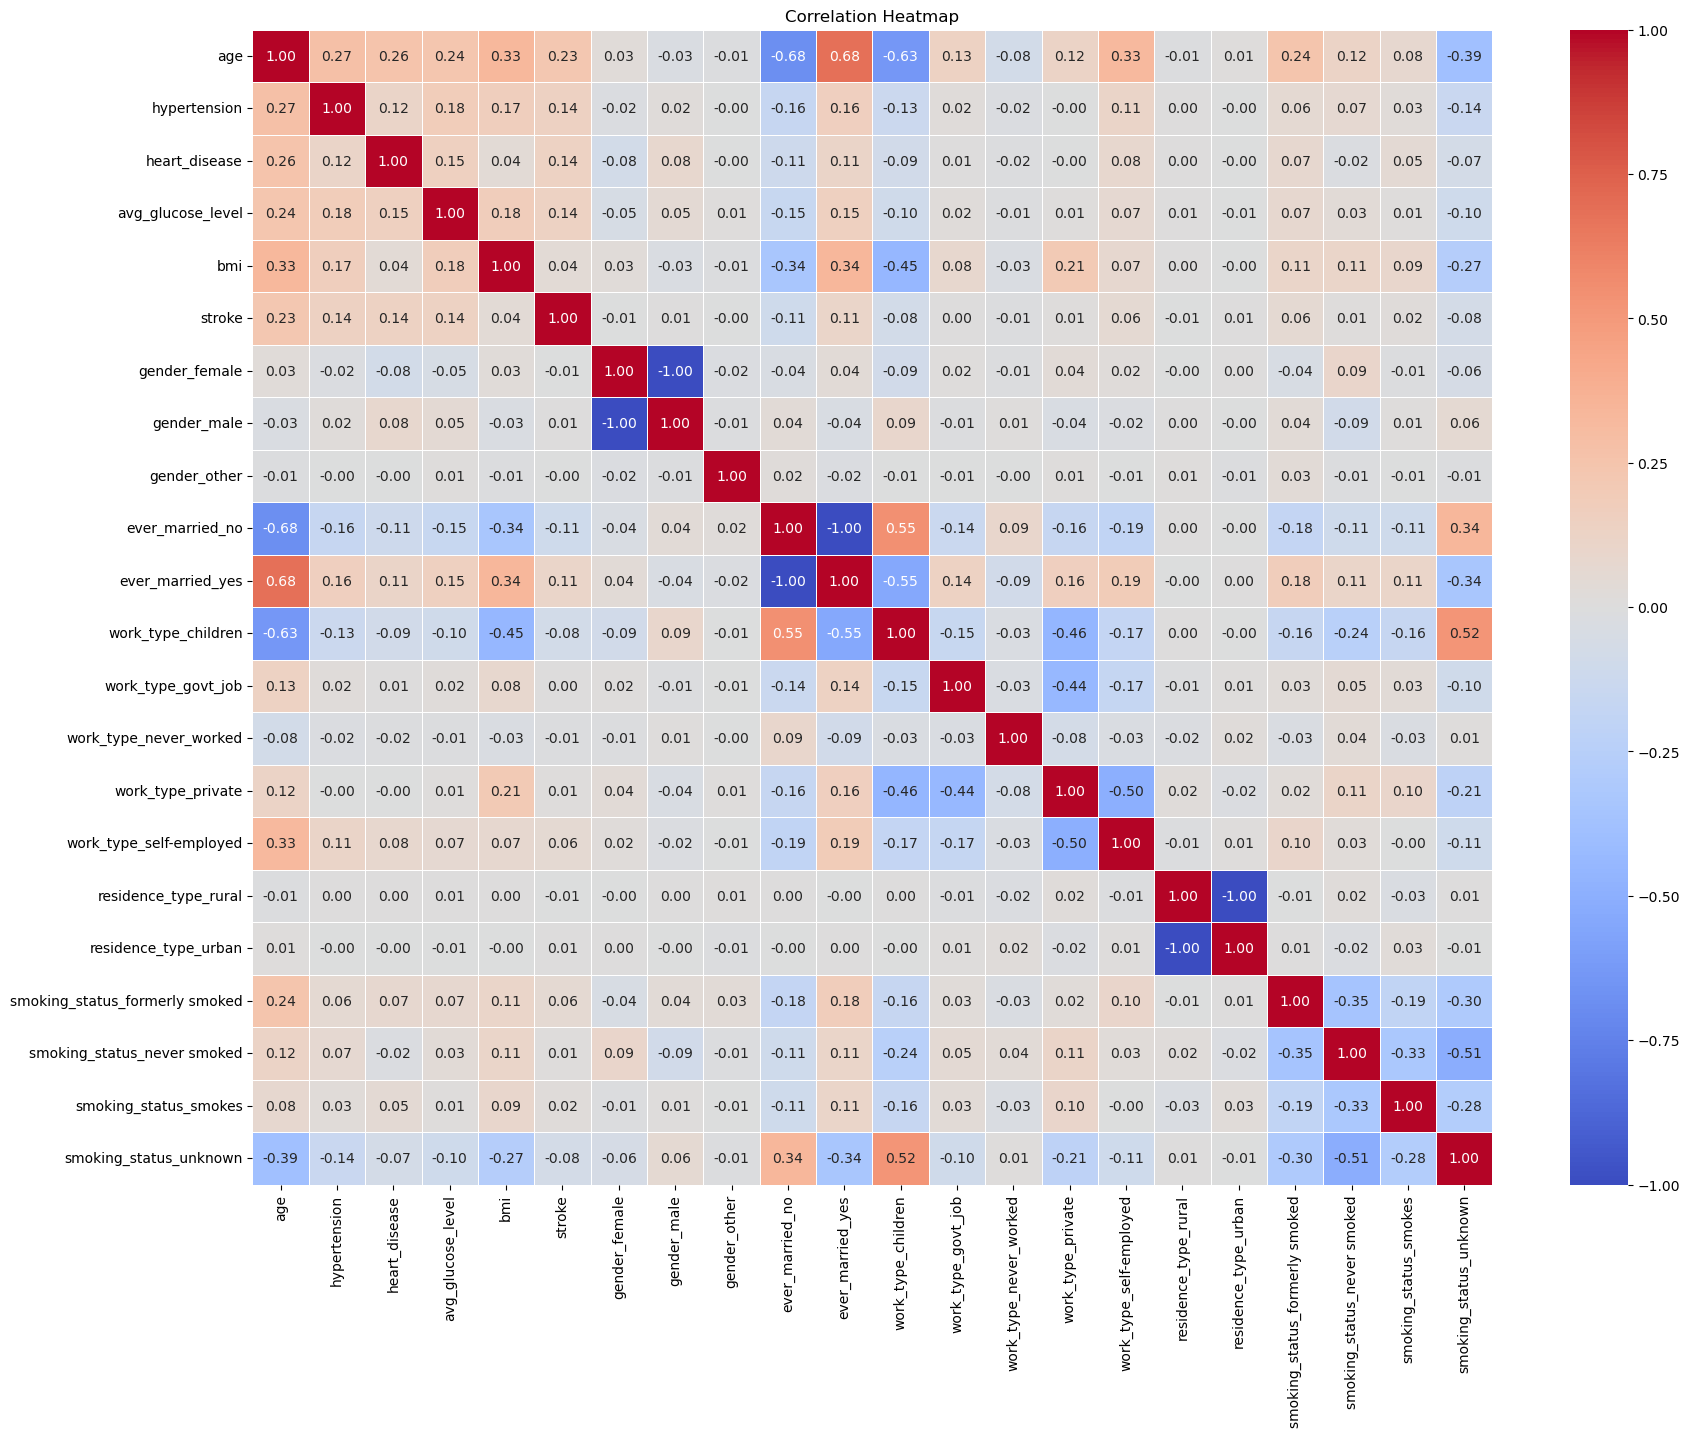

In [8]:
# Correlation Analysis 
cor = df.corr()

# Plot heatmap
pt.figure(figsize = (20,15))
sb.heatmap(cor, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidth = 0.5)
pt.title('Correlation Heatmap')
pt.show()

The correlation matrix illustrates the relationships between the variables with most cases showing a little degree of correlation in grey, negative correlations in blue, and positive correlations in red. There is a slight positive correlation between age and the variables hypertension, heart disease, average glucose level, BMI, stroke, self-employment, and former smokers. This suggests as age increases these variables will also tend to increase. There are a few perfect relationships on categorical variables like urban and rural residence, and gender male and female, which is expected.

## Classification Models

In [9]:
# Separate independent and dependent variables
x = df.drop('stroke', axis = 1)
y = df['stroke']

# 80/20% Training & Test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 11)

# Check the dsitribution of the test set
print('Distribution of the test set:')
print(y_test.value_counts())

Distribution of the test set:
0    929
1     53
Name: stroke, dtype: int64


### Logisitic Regression
#### Initial Model 

In [10]:
# Create additional dataframes for the logistic regression model, maintain originals train test split 
# to use in further classification models 
# For the logistic regression, from the correaltion matrix based on multicollinearity dropping the variable ever_married_yes
# The variable is highly correlated with the complementary variable ever_married_no and the age variable 
lr_x_train = x_train.drop('ever_married_no', axis = 1)
lr_x_test = x_test.drop('ever_married_no', axis = 1)
lr_y_train = y_train 
lr_y_test = y_test 

# Identified Numeric Variables to scale 
numeric_variables = ['age','avg_glucose_level','bmi']
lr_x_train_numeric = lr_x_train[numeric_variables]
lr_x_test_numeric = lr_x_test[numeric_variables]

# Scale numeric variables to 0,1 
scaler = MinMaxScaler()
lr_x_train_scale = scaler.fit_transform(lr_x_train_numeric)
lr_x_test_scale = scaler.fit_transform(lr_x_test_numeric)

# Read back in scaled numeric variables to dataframe 
lr_x_train[numeric_variables] = lr_x_train_scale
lr_x_test[numeric_variables] = lr_x_test_scale 

# Logistic Regression Model 
lr_model = LogisticRegression(random_state = 11) 
lr_model.fit(lr_x_train, lr_y_train)

# Predictions 
lr_predict = lr_model.predict(lr_x_test)

# Accuracy of LR model & Additional Metrics 
lr_accuracy = accuracy_score(lr_y_test, lr_predict)
print(f"Accuracy: {lr_accuracy * 100:.2f}%")

# Classification report
lr_classification_report = classification_report(lr_y_test, lr_predict)
print("Classification Report:\n", lr_classification_report)

# No Information Rate 
no_information_rate = max(lr_y_test.mean(), 1 - lr_y_test.mean())
print(f"No Information Rate (NIR): {no_information_rate * 100:.2f}%")

Accuracy: 94.60%
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982

No Information Rate (NIR): 94.60%


The accuracy of the first iteration of the logisitic regression model is high. However, in the Classification Report for stroke patients the precision, recall, f-score, and support are all zero. The model is not correctly predicting the stroke patients, possibly due to an imbalance in the number of actual stroke patients represented in the sample data. Without the ability to obtain more data for stroke patients, we will attempt to resample using Python package to oversample the minority class of stroke patients utilizing SMOTE (Synthetic Minority Oversampling Technique). 


#### Oversampled/Refined Model

In [11]:
# Oversample the minority class for Stroke 
smote = SMOTE(random_state = 40)
x_train_resample, y_train_resample = smote.fit_resample(x_train, y_train)

# For the logistic regression, from the correaltion matrix based on multicollinearity dropping the variable ever_married_yes
# The variable is highly correlated with the complementary variable ever_married_no and the age variable 
# Create additional dataframes for the logistic regression model, maintain originals train test split 
# to use in further classification models 
lr_x_train = x_train_resample.drop('ever_married_no', axis = 1)   
lr_x_test = x_test.drop('ever_married_no', axis = 1)
lr_y_train = y_train_resample
lr_y_test = y_test 

# Identified Numeric Variables to scale 
numeric_variables = ['age','avg_glucose_level','bmi']
lr_x_train_numeric = lr_x_train[numeric_variables]
lr_x_test_numeric = lr_x_test[numeric_variables]

# Scale numeric variables to 0,1 
scaler = MinMaxScaler()
lr_x_train_scale = scaler.fit_transform(lr_x_train_numeric)
lr_x_test_scale = scaler.fit_transform(lr_x_test_numeric)

# Read back in scaled numeric variables to dataframe 
lr_x_train[numeric_variables] = lr_x_train_scale
lr_x_test[numeric_variables] = lr_x_test_scale 

# Parameter grid 
parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Logistic Regression Model 
# Increasing max iterations
lr_model = LogisticRegression(max_iter = 1000, random_state = 11) 
lr_model.fit(lr_x_train, lr_y_train)

# Create GridSearchCV
grid_search = GridSearchCV(lr_model, parameter_grid, cv = 5)

# Fit model to data 
grid_search.fit(lr_x_train, lr_y_train)

# Best Estimator 
best_lr = grid_search.best_estimator_

# Predictions 
lr_predict = best_lr.predict(lr_x_test)

# Accuracy of LR model & Additional Metrics 
lr_accuracy = accuracy_score(lr_y_test, lr_predict)
print(f"Accuracy: {lr_accuracy * 100:.2f}%")

# Classification Report
lr_classification_report = classification_report(lr_y_test, lr_predict)
print("Classification Report:\n", lr_classification_report)

# No Information Rate 
#lr_y_test_numeric = lr_y_test.map({'No Stroke': 0, 'Stroke': 1})
no_information_rate = max(lr_y_test.mean(), 1 - lr_y_test.mean())
print(f"No Information Rate (NIR): {no_information_rate * 100:.2f}%")

Accuracy: 92.57%
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       929
           1       0.17      0.09      0.12        53

    accuracy                           0.93       982
   macro avg       0.56      0.53      0.54       982
weighted avg       0.91      0.93      0.92       982

No Information Rate (NIR): 94.60%


After oversampling the minority class, the accuracy of the model has decreased slightly but the Classification Report scores for predicting stroke have improved. 

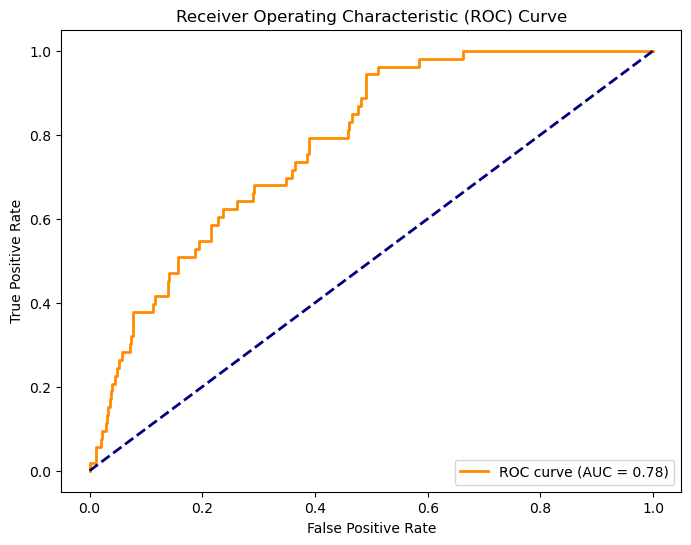

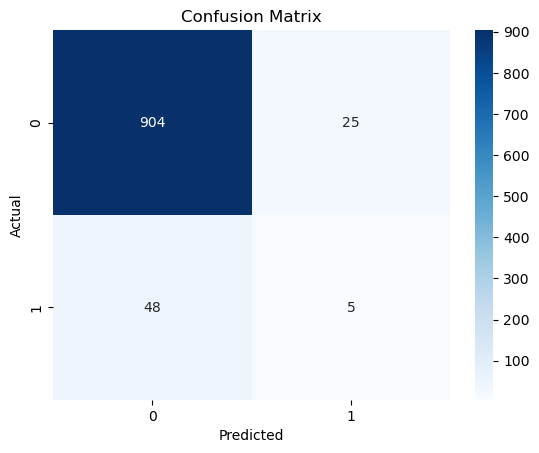

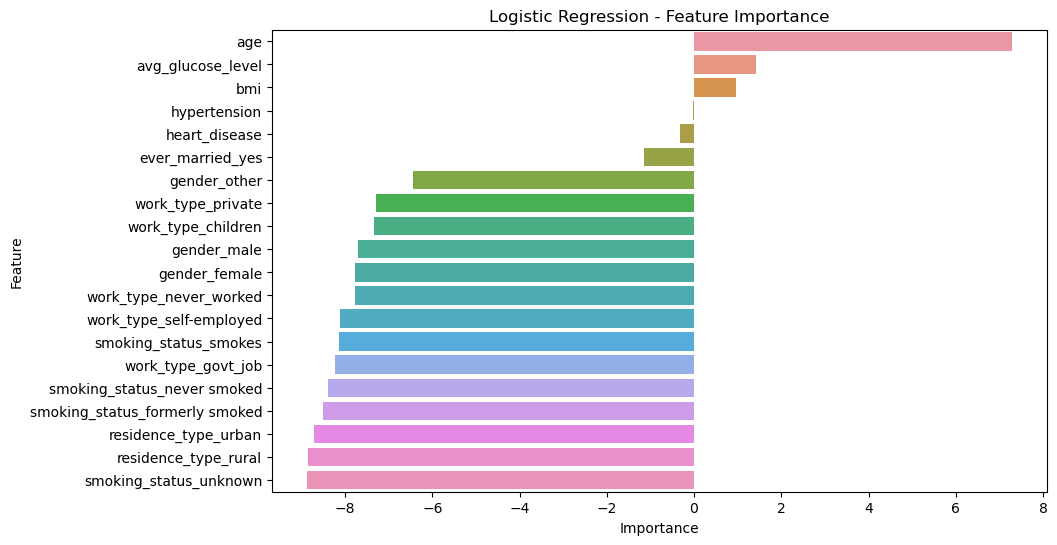

In [12]:
# Get predicted probabilities
lr_probs = best_lr.predict_proba(lr_x_test)[:, 1]
threshold = 0.5

# Make predictions based on the threshold
lr_predictions = (lr_probs > threshold).astype(int)

# Evaluate LR Model performance
roc_auc = roc_auc_score(lr_y_test, lr_probs)

# Plot ROC curve
fpr, tpr, _ = roc_curve(lr_y_test, lr_probs)
roc_auc = auc(fpr, tpr)
pt.figure(figsize = (8, 6))
pt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {roc_auc:.2f})')
pt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
pt.xlabel('False Positive Rate')
pt.ylabel('True Positive Rate')
pt.title('Receiver Operating Characteristic (ROC) Curve')
pt.legend(loc = 'lower right')
pt.show()

# Confusion Matrix
matrix = confusion_matrix(lr_y_test, lr_predict)
sb.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Blues')
pt.xlabel('Predicted')
pt.ylabel('Actual')
pt.title('Confusion Matrix')
pt.show()

# Feature Importance 
feature_importance = pd.DataFrame({'Feature': lr_x_train.columns, 'Importance': best_lr.coef_[0]})
feature_importance = feature_importance.sort_values(by = 'Importance', ascending = False)
pt.figure(figsize = (10, 6))
sb.barplot(x = 'Importance', y = 'Feature', data = feature_importance)
pt.title('Logistic Regression - Feature Importance')
pt.show()

##### ROC Curve
The ROC Curve shaded in yellow represents the performance of the dependent variable, the higher that curve is from the random classifier (dashed blue line) the better the performance of the model. The AUC (Area Under the Curve) of .78 suggests that the logistic regression model is able to distinguish between the stroke and non-stroke patients


##### Confusion Matrix 
The top right represents the "True Negatives", the number of times of actual non-stroke versus the number of times the model predicted non-stroke correctly. The bottom left is the "False Negatives", the number of times of actual strokes but were predicted as non-stroke through the model. The top right is the "False Positives", the number of patients that are non-strokes but were predicted as strokes incorrectly. The bottom right is the "True Positives", the number of actual strokes and predicted strokes correctly through the logistic regression model. The refined oversampled model has correctly identified 904 non-stroke patients and 5 stroke patients. However, the model has incorrectly predicted 73 patients, 48 as false negatives and 25 false positives. 

##### Feature Importance Bar Chart
The age variable has the highest importance compared to the other variables. An increase in age has a positive affect on the model predicting the patient having a stroke.

#### Logistic Regression Model Refine Model Reduce Age Noise

Distribution of the test set:
0    516
1     43
Name: stroke, dtype: int64
Accuracy: 92.13%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       516
           1       0.40      0.05      0.08        43

    accuracy                           0.92       559
   macro avg       0.66      0.52      0.52       559
weighted avg       0.89      0.92      0.89       559

No Information Rate (NIR): 92.31%


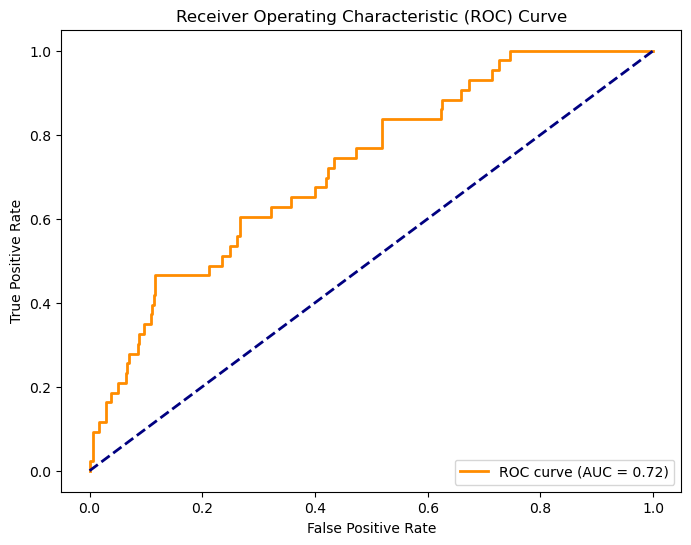

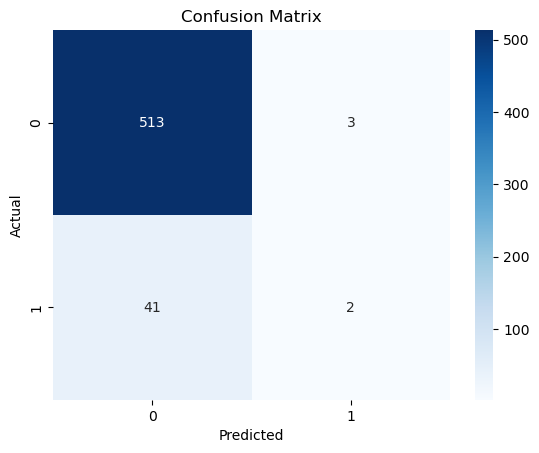

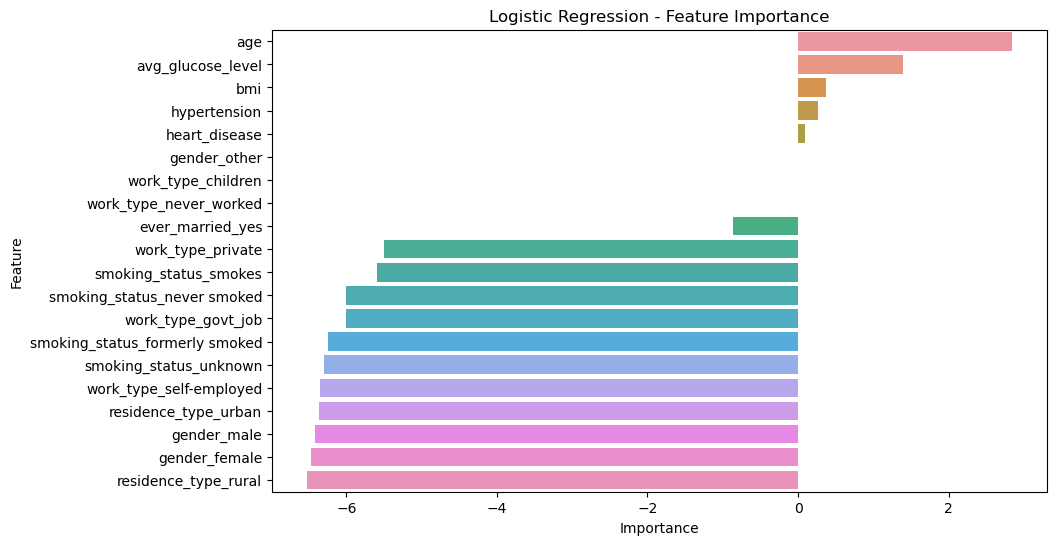

In [37]:
reg_model = df.copy()

reg_model = reg_model[reg_model['age'] >= 40]

# Separate independent and dependent variables
reg_x = reg_model.drop('stroke', axis = 1)
reg_y = reg_model['stroke']

# 80/20% Training & Test data
reg_x_train, reg_x_test, reg_y_train, reg_y_test = train_test_split(reg_x, reg_y, test_size = .2, random_state = 11)

# Check the dsitribution of the test set
print('Distribution of the test set:')
print(reg_y_test.value_counts())

# Oversample the minority class for Stroke 
smote = SMOTE(random_state = 40)
reg_x_train_resample, reg_y_train_resample = smote.fit_resample(reg_x_train, reg_y_train)

# For the logistic regression, from the correaltion matrix based on multicollinearity dropping the variable ever_married_yes
# The variable is highly correlated with the complementary variable ever_married_no and the age variable 
# Create additional dataframes for the logistic regression model, maintain originals train test split 
# to use in further classification models 
reg_lr_x_train = reg_x_train_resample.drop('ever_married_no', axis = 1)   
reg_lr_x_test = reg_x_test.drop('ever_married_no', axis = 1)
reg_lr_y_train = reg_y_train_resample
reg_lr_y_test = reg_y_test 

# Identified Numeric Variables to scale 
numeric_variables = ['age','avg_glucose_level','bmi']
reg_lr_x_train_numeric = reg_lr_x_train[numeric_variables]
reg_lr_x_test_numeric = reg_lr_x_test[numeric_variables]

# Scale numeric variables to 0,1 
scaler = MinMaxScaler()
reg_lr_x_train_scale = scaler.fit_transform(reg_lr_x_train_numeric)
reg_lr_x_test_scale = scaler.fit_transform(reg_lr_x_test_numeric)

# Read back in scaled numeric variables to dataframe 
reg_lr_x_train[numeric_variables] = reg_lr_x_train_scale
reg_lr_x_test[numeric_variables] = reg_lr_x_test_scale 

# Parameter grid 
parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Logistic Regression Model 
# Increasing max iterations
reg_lr_model = LogisticRegression(max_iter = 1000, random_state = 11) 
reg_lr_model.fit(reg_lr_x_train, reg_lr_y_train)

# Create GridSearchCV
grid_search = GridSearchCV(reg_lr_model, parameter_grid, cv = 5)

# Fit model to data 
grid_search.fit(reg_lr_x_train, reg_lr_y_train)

# Best Estimator 
best_lr = grid_search.best_estimator_

# Predictions 
reg_lr_predict = best_lr.predict(reg_lr_x_test)

# Accuracy of LR model & Additional Metrics 
reg_lr_accuracy = accuracy_score(reg_lr_y_test, reg_lr_predict)
print(f"Accuracy: {reg_lr_accuracy * 100:.2f}%")

# Classification Report
reg_lr_classification_report = classification_report(reg_lr_y_test, reg_lr_predict)
print("Classification Report:\n", reg_lr_classification_report)

# No Information Rate 
#lr_y_test_numeric = lr_y_test.map({'No Stroke': 0, 'Stroke': 1})
reg_no_information_rate = max(reg_lr_y_test.mean(), 1 - reg_lr_y_test.mean())
print(f"No Information Rate (NIR): {reg_no_information_rate * 100:.2f}%")


# Get predicted probabilities
reg_lr_probs = best_lr.predict_proba(reg_lr_x_test)[:, 1]
threshold = 0.5

# Make predictions based on the threshold
reg_lr_predictions = (reg_lr_probs > threshold).astype(int)

# Evaluate LR Model performance
reg_roc_auc = roc_auc_score(reg_lr_y_test, reg_lr_probs)

# Plot ROC curve
reg_fpr, reg_tpr, _ = roc_curve(reg_lr_y_test, reg_lr_probs)
reg_roc_auc = auc(reg_fpr, reg_tpr)
pt.figure(figsize = (8, 6))
pt.plot(reg_fpr, reg_tpr, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {reg_roc_auc:.2f})')
pt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
pt.xlabel('False Positive Rate')
pt.ylabel('True Positive Rate')
pt.title('Receiver Operating Characteristic (ROC) Curve')
pt.legend(loc = 'lower right')
pt.show()

# Confusion Matrix
reg_matrix = confusion_matrix(reg_lr_y_test, reg_lr_predict)
sb.heatmap(reg_matrix, annot = True, fmt = 'd', cmap = 'Blues')
pt.xlabel('Predicted')
pt.ylabel('Actual')
pt.title('Confusion Matrix')
pt.show()

# Feature Importance 
reg_feature_importance = pd.DataFrame({'Feature': reg_lr_x_train.columns, 'Importance': best_lr.coef_[0]})
reg_feature_importance = reg_feature_importance.sort_values(by = 'Importance', ascending = False)
pt.figure(figsize = (10, 6))
sb.barplot(x = 'Importance', y = 'Feature', data = reg_feature_importance)
pt.title('Logistic Regression - Feature Importance')
pt.show()

Here we attempted to reduce the noise of the age variable and reduced the population down substainally by removing patients under the age of forty years old. From the EDA portion, we found that most of the stroke patients were greater than forty years old and the sample population contained few stroke patients (< 5%). The model still does well in predicting the non-stroke patients but struggles with predicting the stroke patients. 

The accuracy of the model decreased two tenths of a percentage point, with the precision score for stroke class improving substainally. In the testing dataset the 43 stroke patients didn't fare well with only 2 of 43 correctly predicted and 41 misindetified. 

Reducing the data for older patients decreased the feature importance of age, average glucose, bmi, and hypertension. 

#### Logistic Regression UnderSampling Majority Class/Cross-Validation/Expanding Test Size

Accuracy: 73.53%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.74      0.84      1168
           1       0.12      0.73      0.21        60

    accuracy                           0.74      1228
   macro avg       0.55      0.73      0.53      1228
weighted avg       0.94      0.74      0.81      1228

No Information Rate (NIR): 95.11%


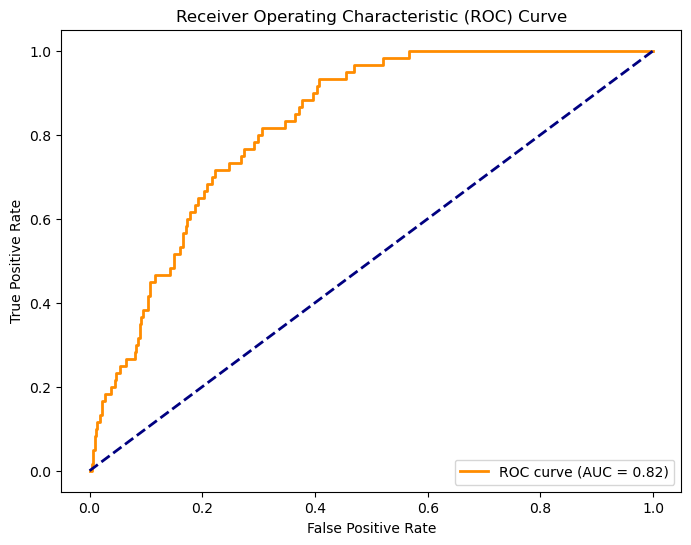

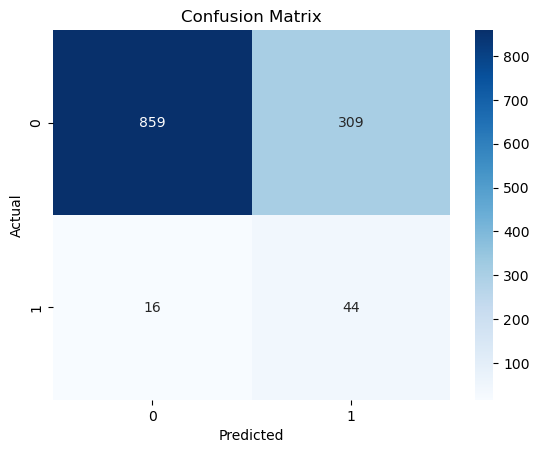

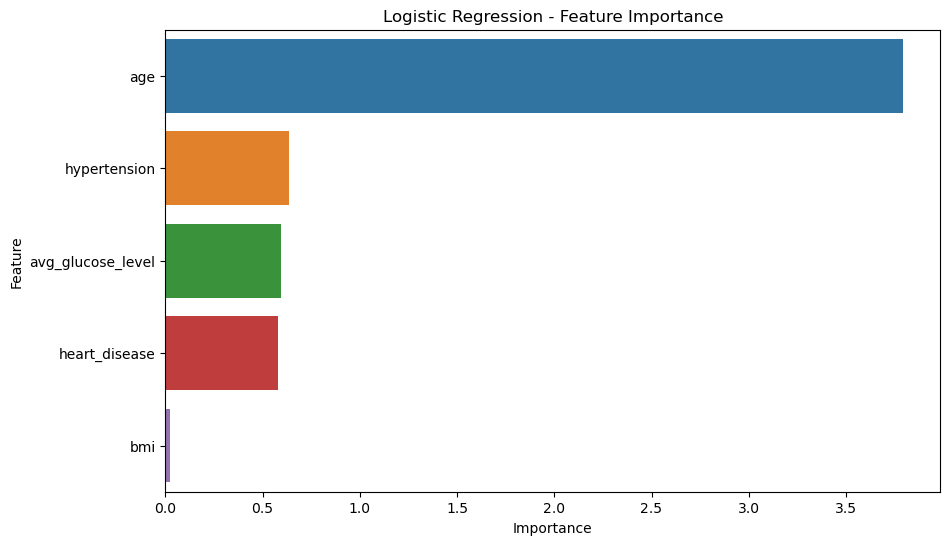

In [60]:
#under sample the majority class stroke = 0
us_reg_model = df.copy()

us_reg_model = reg_model[reg_model['age'] >= 40]

# Separate independent and dependent variables
us_reg_x = df.drop('stroke', axis = 1)
us_reg_y = df['stroke']

# 80/25% Training & Test data
us_reg_x_train, us_reg_x_test, us_reg_y_train, us_reg_y_test = train_test_split(us_reg_x, us_reg_y, test_size = 0.25, random_state = 11)

# Undersample the majority class
under_sample = RandomUnderSampler(sampling_strategy = 'majority', random_state = 11)
us_reg_x_train_resample, us_reg_y_train_resample = under_sample.fit_resample(us_reg_x_train, us_reg_y_train)

# Columns to drop
col_drop = ['gender_female', 'gender_male', 'gender_other', 'ever_married_yes', 'ever_married_no',
            'work_type_children', 'work_type_govt_job', 'work_type_never_worked', 'work_type_private',
            'work_type_self-employed', 'residence_type_rural', 'residence_type_urban',
            'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes',
            'smoking_status_unknown']

# Drop columns
us_reg_lr_x_train_resample = us_reg_x_train_resample.drop(columns=col_drop, axis=1)
us_reg_lr_x_test = us_reg_x_test.drop(columns=col_drop, axis=1)

# Identified Numeric Variables to scale
numeric_variables = ['age', 'avg_glucose_level', 'bmi']
us_reg_lr_x_train_numeric = us_reg_lr_x_train_resample[numeric_variables]
us_reg_lr_x_test_numeric = us_reg_lr_x_test[numeric_variables]

# Scale numeric variables to 0,1
scaler = MinMaxScaler()
us_reg_lr_x_train_scale = scaler.fit_transform(us_reg_lr_x_train_numeric)
us_reg_lr_x_test_scale = scaler.fit_transform(us_reg_lr_x_test_numeric)

# Read back in scaled numeric variables to the dataframe
us_reg_lr_x_train_resample[numeric_variables] = us_reg_lr_x_train_scale
us_reg_lr_x_test[numeric_variables] = us_reg_lr_x_test_scale

# Parameter grid
parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Logistic Regression Model
# Increasing max iterations
us_reg_lr_model = LogisticRegression(max_iter=1000, random_state=11)

# Define the cross-validation strategy (StratifiedKFold for handling imbalanced classes)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 11)

# Create GridSearchCV
grid_search = GridSearchCV(us_reg_lr_model, parameter_grid, cv = cv)

# Fit model to data with cross-validation
grid_search.fit(us_reg_lr_x_train_resample, us_reg_y_train_resample)

# Best Estimator
best_lr = grid_search.best_estimator_

# Predictions
us_reg_lr_predict = best_lr.predict(us_reg_lr_x_test)

# Accuracy of LR model & Additional Metrics
us_reg_lr_accuracy = accuracy_score(us_reg_y_test, us_reg_lr_predict)
print(f"Accuracy: {us_reg_lr_accuracy * 100:.2f}%")

# Classification Report
us_reg_lr_classification_report = classification_report(us_reg_y_test, us_reg_lr_predict)
print("Classification Report:\n", us_reg_lr_classification_report)

# No Information Rate
us_reg_no_information_rate = max(us_reg_y_test.mean(), 1 - us_reg_y_test.mean())
print(f"No Information Rate (NIR): {us_reg_no_information_rate * 100:.2f}%")

# Get predicted probabilities
us_reg_lr_probs = best_lr.predict_proba(us_reg_lr_x_test)[:, 1]
threshold = 0.50

# Make predictions based on the threshold
us_reg_lr_predictions = (us_reg_lr_probs > threshold).astype(int)

# Evaluate LR Model performance
us_reg_roc_auc = roc_auc_score(us_reg_y_test, us_reg_lr_probs)

# Plot ROC curve
us_reg_fpr, us_reg_tpr, _ = roc_curve(us_reg_y_test, us_reg_lr_probs)
us_reg_roc_auc = auc(us_reg_fpr, us_reg_tpr)
pt.figure(figsize = (8, 6))
pt.plot(us_reg_fpr, us_reg_tpr, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {us_reg_roc_auc:.2f})')
pt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
pt.xlabel('False Positive Rate')
pt.ylabel('True Positive Rate')
pt.title('Receiver Operating Characteristic (ROC) Curve')
pt.legend(loc='lower right')
pt.show()

# Confusion Matrix
us_reg_matrix = confusion_matrix(us_reg_y_test, us_reg_lr_predict)
sb.heatmap(us_reg_matrix, annot = True, fmt = 'd', cmap = 'Blues')
pt.xlabel('Predicted')
pt.ylabel('Actual')
pt.title('Confusion Matrix')
pt.show()

# Feature Importance
us_reg_feature_importance = pd.DataFrame({'Feature': us_reg_lr_x_train_resample.columns, 'Importance': best_lr.coef_[0]})
us_reg_feature_importance = us_reg_feature_importance.sort_values(by = 'Importance', ascending = False)
pt.figure(figsize = (10, 6))
sb.barplot(x = 'Importance', y = 'Feature', data = us_reg_feature_importance)
pt.title('Logistic Regression - Feature Importance')
pt.show()

For further exploration to refine the logisitc regression model, we removed most of the binary variables to focus solely on age, hypertension, average glucose level, heart disease and bmi. This model only had a 73.53% accuracy but the model in correctly identified 44 stroke patients and 859 non-stroke patients. As seen in previous models, age has the highest feature importance in this model. We also expanded the test population size to 75/25% training and test data.

#### LR Model Utilizing StatsModels Logit Function 

In [13]:
np.random.seed(11)

# For the logistic regression, from the correaltion matrix based on multicollinearity dropping the variable ever_married_yes
# The variable is highly correlated with the complementary variable ever_married_no and the age variable 
sm_lr_x_train = x_train.drop('ever_married_no', axis = 1)
sm_lr_x_test = x_test.drop('ever_married_no', axis = 1)
sm_lr_y_train = y_train 
sm_lr_y_test = y_test 

# Fit the model 
sm_lr_model = sm.Logit(sm_lr_y_train, sm.add_constant(sm_lr_x_train)).fit(maxiter = 1000)

# Predictions 
sm_lr_predict = sm_lr_model.predict(sm.add_constant(sm_lr_x_test))
sm_lr_predict_var = (sm_lr_predict > 0.5).astype(int)

# Model Summary and Metrics 
print(sm_lr_model.summary())

sm_lr_accuracy = accuracy_score(sm_lr_y_test, sm_lr_predict_var)
print(f"Accuracy: {sm_lr_accuracy * 100:.2f}%")

sm_lr_class_report = classification_report(sm_lr_y_test, sm_lr_predict_var)
print("Classification Report:\n", sm_lr_class_report)

Optimization terminated successfully.
         Current function value: 0.128283
         Iterations 621
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 3927
Model:                          Logit   Df Residuals:                     3910
Method:                           MLE   Df Model:                           16
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2322
Time:                        13:27:08   Log-Likelihood:                -503.77
converged:                       True   LL-Null:                       -656.08
Covariance Type:            nonrobust   LLR p-value:                 2.803e-55
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -35.1479        nan        nan   

Utilizing a different Python package to run a logisitic regression to generate p-values and statisical values the initial model from the statsmodel is close in performance to sklearn. The Model has a high accuracy percentage but analyzing the pseudo-R squared is at 23%, measuring the goodness of fit in this model is quite low. Additional red flags in the summary show high p-values on the categorical variables, and the classification report for predicting stroke on precision, recall, and f-1 scores are all zero. 

We will attempt to refine the logit model. 

#### Logit Model Refined/Oversampled

In [14]:
np.random.seed(11)

# Refine the model & Oversample 
# For the logistic regression, from the correaltion matrix based on multicollinearity dropping the variable ever_married_yes
# The variable is highly correlated with the complementary variable ever_married_no and the age variable 
col_drop = ['gender_female','gender_male','gender_other','ever_married_yes','ever_married_no',
            'work_type_children','work_type_govt_job','work_type_never_worked','work_type_private',
            'work_type_self-employed','residence_type_rural','residence_type_urban','smoking_status_formerly smoked',
            'smoking_status_never smoked','smoking_status_smokes','smoking_status_unknown']

sm_lr_x_train = x_train_resample.drop(columns = col_drop, axis = 1)
sm_lr_x_test = x_test.drop(columns = col_drop, axis = 1)
sm_lr_y_train = y_train_resample 
sm_lr_y_test = y_test 

# Fit the model 
sm_lr_model = sm.Logit(sm_lr_y_train, sm.add_constant(sm_lr_x_train)).fit(maxiter = 1000)

# Predictions 
sm_lr_predict = sm_lr_model.predict(sm.add_constant(sm_lr_x_test))
sm_lr_predict_var = (sm_lr_predict > 0.5).astype(int)

# Model Summary and Metrics 
print(sm_lr_model.summary())

sm_lr_accuracy = accuracy_score(sm_lr_y_test, sm_lr_predict_var)
print(f"Accuracy: {sm_lr_accuracy * 100:.2f}%")

sm_lr_class_report = classification_report(sm_lr_y_test, sm_lr_predict_var)
print("Classification Report:\n", sm_lr_class_report)

Optimization terminated successfully.
         Current function value: 0.436871
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 7542
Model:                          Logit   Df Residuals:                     7536
Method:                           MLE   Df Model:                            5
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.3697
Time:                        13:27:08   Log-Likelihood:                -3294.9
converged:                       True   LL-Null:                       -5227.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.6879      0.225    -29.777      0.000      -7.128      -6.248
age     

After removing the categorical variabnles, oversampling the minority stroke patients, the model has decreased in accuracy but precision, recall, f-1 score, and pseduo R-squared percentages have increased. The model still struggles in predicting the stroke patients. The coefficents for age, average glucose lebel, and bmi are all postive variables, suggesting that the likelihood of stroke increase. Surprisingly, hypertension and heart disease are both negative coefficents suggesting a decrease in the likelihood of stroke. 

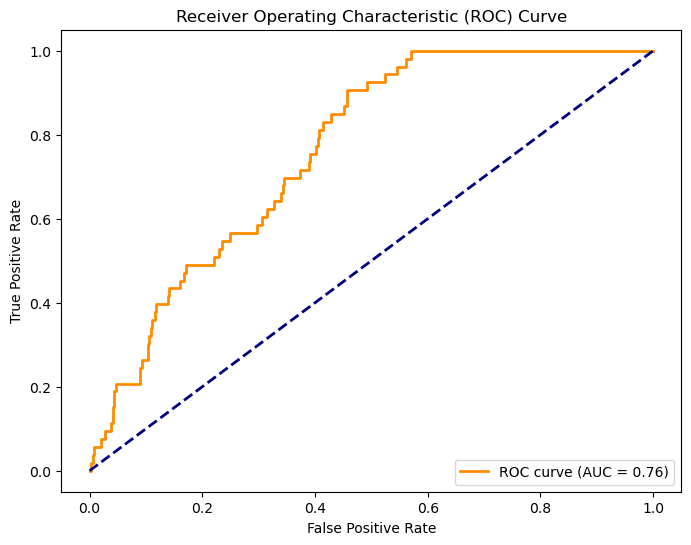

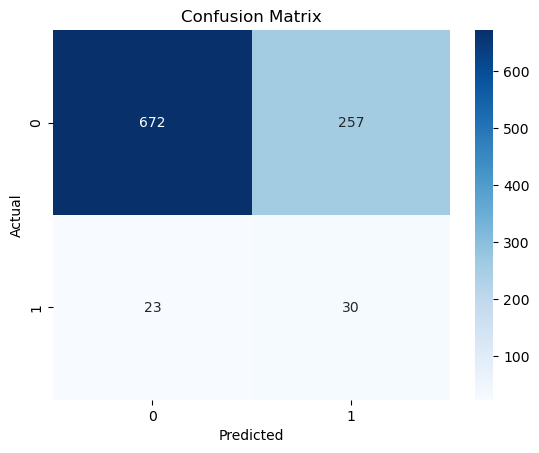

In [15]:
# Get predicted probabilities
sm_lr_probs = sm_lr_model.predict(sm.add_constant(sm_lr_x_test))
threshold = 0.50

# Make predictions based on the threshold
sm_lr_predictions = (sm_lr_probs > threshold).astype(int)

# Evaluate LR Model performance
roc_auc = roc_auc_score(sm_lr_y_test, sm_lr_probs)

# Evaluate LR Model performance
roc_auc = roc_auc_score(sm_lr_y_test, sm_lr_probs)

# Plot ROC curve
fpr, tpr, _ = roc_curve(sm_lr_y_test, sm_lr_probs)
roc_auc = auc(fpr, tpr)
pt.figure(figsize=(8, 6))
pt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
pt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
pt.xlabel('False Positive Rate')
pt.ylabel('True Positive Rate')
pt.title('Receiver Operating Characteristic (ROC) Curve')
pt.legend(loc='lower right')
pt.show()

# Confusion Matrix
matrix = confusion_matrix(sm_lr_y_test, sm_lr_predictions)
sb.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
pt.xlabel('Predicted')
pt.ylabel('Actual')
pt.title('Confusion Matrix')
pt.show()

The refined logit model correctly identifies 672 non-stroke patients and 30 stroke patients. This model didn't perform as well as the logisitic function from the Sklearn package with similar pre-processing where we removed most of the binary variables.

### Decision Tree & Random Forest
#### Initial Models

In [16]:
# Descision Tree Model 
dt = DecisionTreeClassifier(random_state = 11)

# DT Model fitting 
dt.fit(x_train, y_train)

# DT Predictions 
dt_predict = dt.predict(x_test)

# Random Forest Model 
rf = RandomForestClassifier(random_state = 11)

# RF Model fitting 
rf.fit(x_train, y_train)

# RF Predictions
rf_predict = rf.predict(x_test)

# Accuracy of Decision Tree Model & Additional Metrics 
# Evaluate Decision Tree performance
dt_accuracy = accuracy_score(y_test, dt_predict)
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")

# Classification Report
dt_classification_report = classification_report(y_test, dt_predict)
print("Decision Tree Classification Report:\n", dt_classification_report)

# Accuracy of Random Forest Model & Additional Metrics 
# Evaluate Random Forest performance
rf_accuracy = accuracy_score(y_test, rf_predict)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

# RF Classification Report
rf_classification_report = classification_report(y_test, rf_predict)
print("Random Forest Classification Report:\n", rf_classification_report)

Decision Tree Accuracy: 90.73%
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       929
           1       0.09      0.08      0.08        53

    accuracy                           0.91       982
   macro avg       0.52      0.52      0.52       982
weighted avg       0.90      0.91      0.90       982

Random Forest Accuracy: 94.50%
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



The initial decision tree models performed similar to the logisitc regression intial models, high accuracy prediction but struggle in stroke prediction. 

#### Oversampled Models

In [17]:
# For the logistic regression, from the correaltion matrix based on multicollinearity dropping the variable ever_married_yes
# The variable is highly correlated with the complementary variable ever_married_no and the age variable 
# Create additional dataframes for the logistic regression model, maintain originals train test split 
# to use in further classification models 
t_x_train = x_train_resample.drop('ever_married_no', axis = 1)   
t_x_test = x_test.drop('ever_married_no', axis = 1)
t_y_train = y_train_resample
t_y_test = y_test 

# Descision Tree Model w/Oversampled Data  
dt_os = DecisionTreeClassifier(random_state = 11)

# DT Model fitting 
dt_os.fit(t_x_train, t_y_train)

# DT Predictions 
dt_predict_os = dt_os.predict(t_x_test)

# Random Forest Model 
rf_os = RandomForestClassifier(random_state = 11)

# RF Model fitting 
rf_os.fit(t_x_train, t_y_train)

# RF Predictions
rf_predict_os = rf_os.predict(t_x_test)

# Accuracy of Decision Tree Model & Additional Metrics 
# Evaluate Decision Tree performance
dt_accuracy_os = accuracy_score(t_y_test, dt_predict_os)
print(f"Decision Tree Accuracy: {dt_accuracy_os * 100:.2f}%")

# Classification Report
dt_classification_report_os = classification_report(t_y_test, dt_predict_os)
print("Decision Tree Classification Report:\n", dt_classification_report_os)

# Accuracy of Random Forest Model & Additional Metrics 
# Evaluate Random Forest performance
rf_accuracy_os = accuracy_score(t_y_test, rf_predict_os)
print(f"Random Forest Accuracy: {rf_accuracy_os * 100:.2f}%")

# RF Classification Report
rf_classification_report_os = classification_report(t_y_test, rf_predict_os)
print("Random Forest Classification Report:\n", rf_classification_report_os)

Decision Tree Accuracy: 90.33%
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       929
           1       0.14      0.15      0.14        53

    accuracy                           0.90       982
   macro avg       0.54      0.55      0.55       982
weighted avg       0.91      0.90      0.91       982

Random Forest Accuracy: 93.28%
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.93       982
   macro avg       0.47      0.49      0.48       982
weighted avg       0.89      0.93      0.91       982



After oversampling the decision tree and random forest models, the random forest still is struggling to predict stroke but both have high accuracy percentages. The Decision tree accuracy slightly decreased but stroke prediction has slightly improved. 

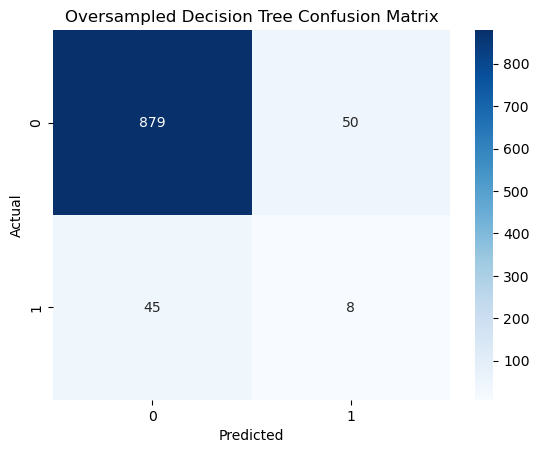

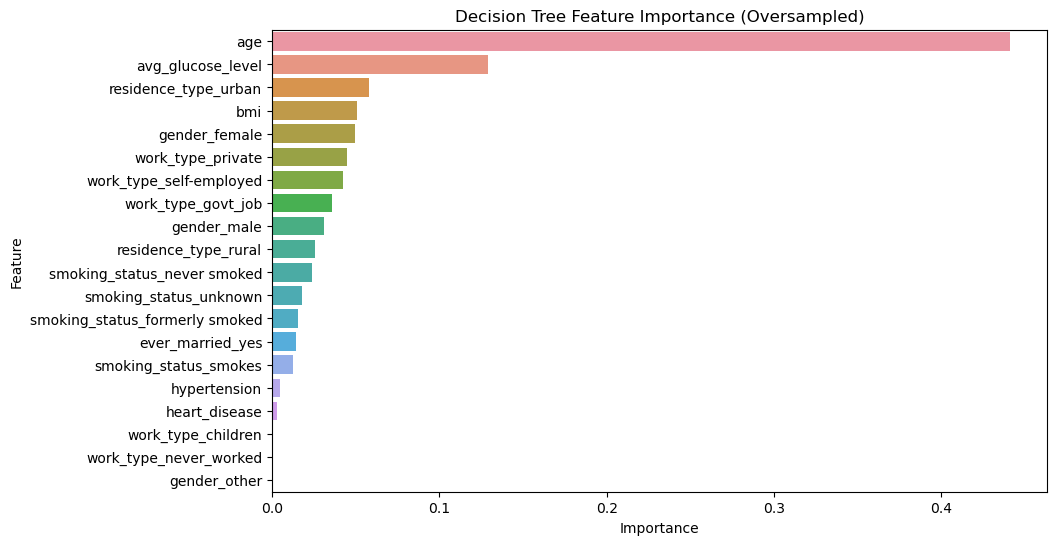

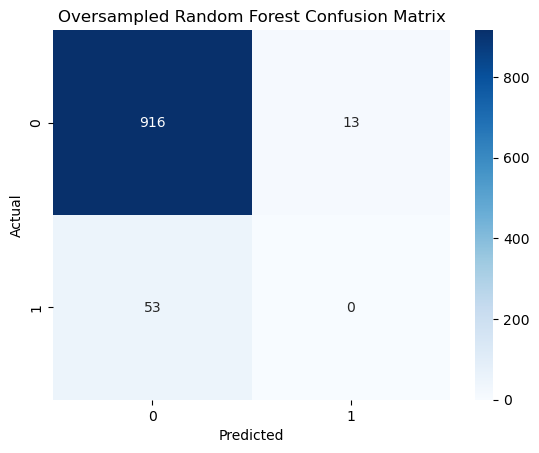

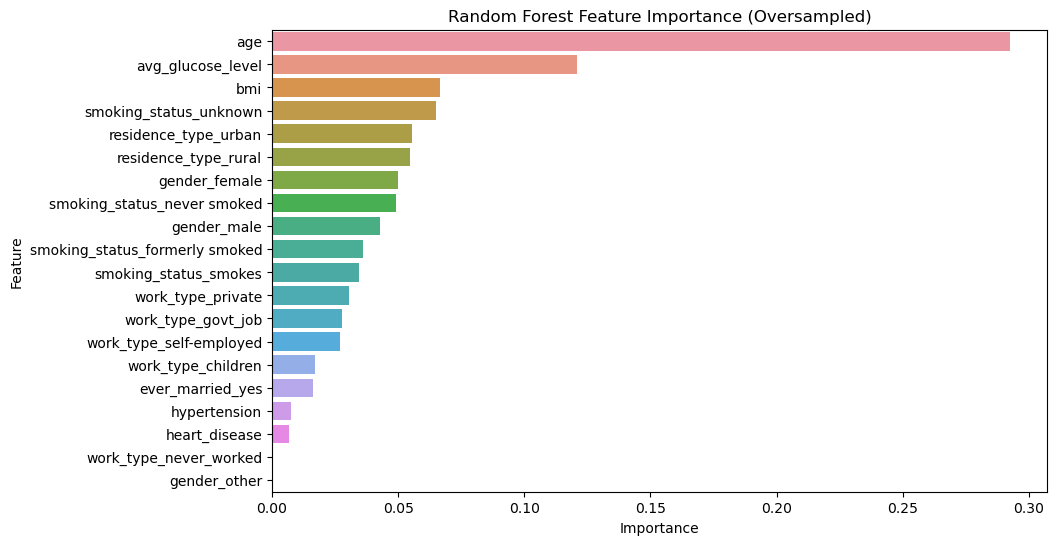

In [18]:
# Oversampled Decision Tree Confusion Matrix 
dt_matrix = confusion_matrix(t_y_test, dt_predict_os)
sb.heatmap(dt_matrix, annot = True, fmt = 'd', cmap = 'Blues')
pt.xlabel('Predicted')
pt.ylabel('Actual')
pt.title('Oversampled Decision Tree Confusion Matrix')
pt.show()

# Oversampled Decision Tree Feature Importance
dt_feature_importance = dt_os.feature_importances_
dt_feature_df = pd.DataFrame({'Feature': t_x_train.columns, 'Importance': dt_feature_importance})
dt_feature_df = dt_feature_df.sort_values(by = 'Importance', ascending=False)
pt.figure(figsize = (10, 6))
sb.barplot(x = 'Importance', y = 'Feature', data = dt_feature_df)
pt.title('Decision Tree Feature Importance (Oversampled)')
pt.show()

# Oversampled Decision Tree Confusion Matrix 
rf_matrix = confusion_matrix(t_y_test, rf_predict_os)
sb.heatmap(rf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
pt.xlabel('Predicted')
pt.ylabel('Actual')
pt.title('Oversampled Random Forest Confusion Matrix')
pt.show()

# Oversampled Decision Tree Feature Importance
rf_feature_importance = rf_os.feature_importances_
rf_feature_df = pd.DataFrame({'Feature': t_x_train.columns, 'Importance': rf_feature_importance})
rf_feature_df = rf_feature_df.sort_values(by = 'Importance', ascending=False)
pt.figure(figsize = (10, 6))
sb.barplot(x = 'Importance', y = 'Feature', data = rf_feature_df)
pt.title('Random Forest Feature Importance (Oversampled)')
pt.show()

The feautre importance plots show all positive importance relationships, conflicting to the logisticr regression feature importance plots that only showed age, average glucose level, and BMI as positive feature variables. The decision tree oversampled model correctly identified eight stroke patients and the random forest model incorrectly predicted all stroke patients. 

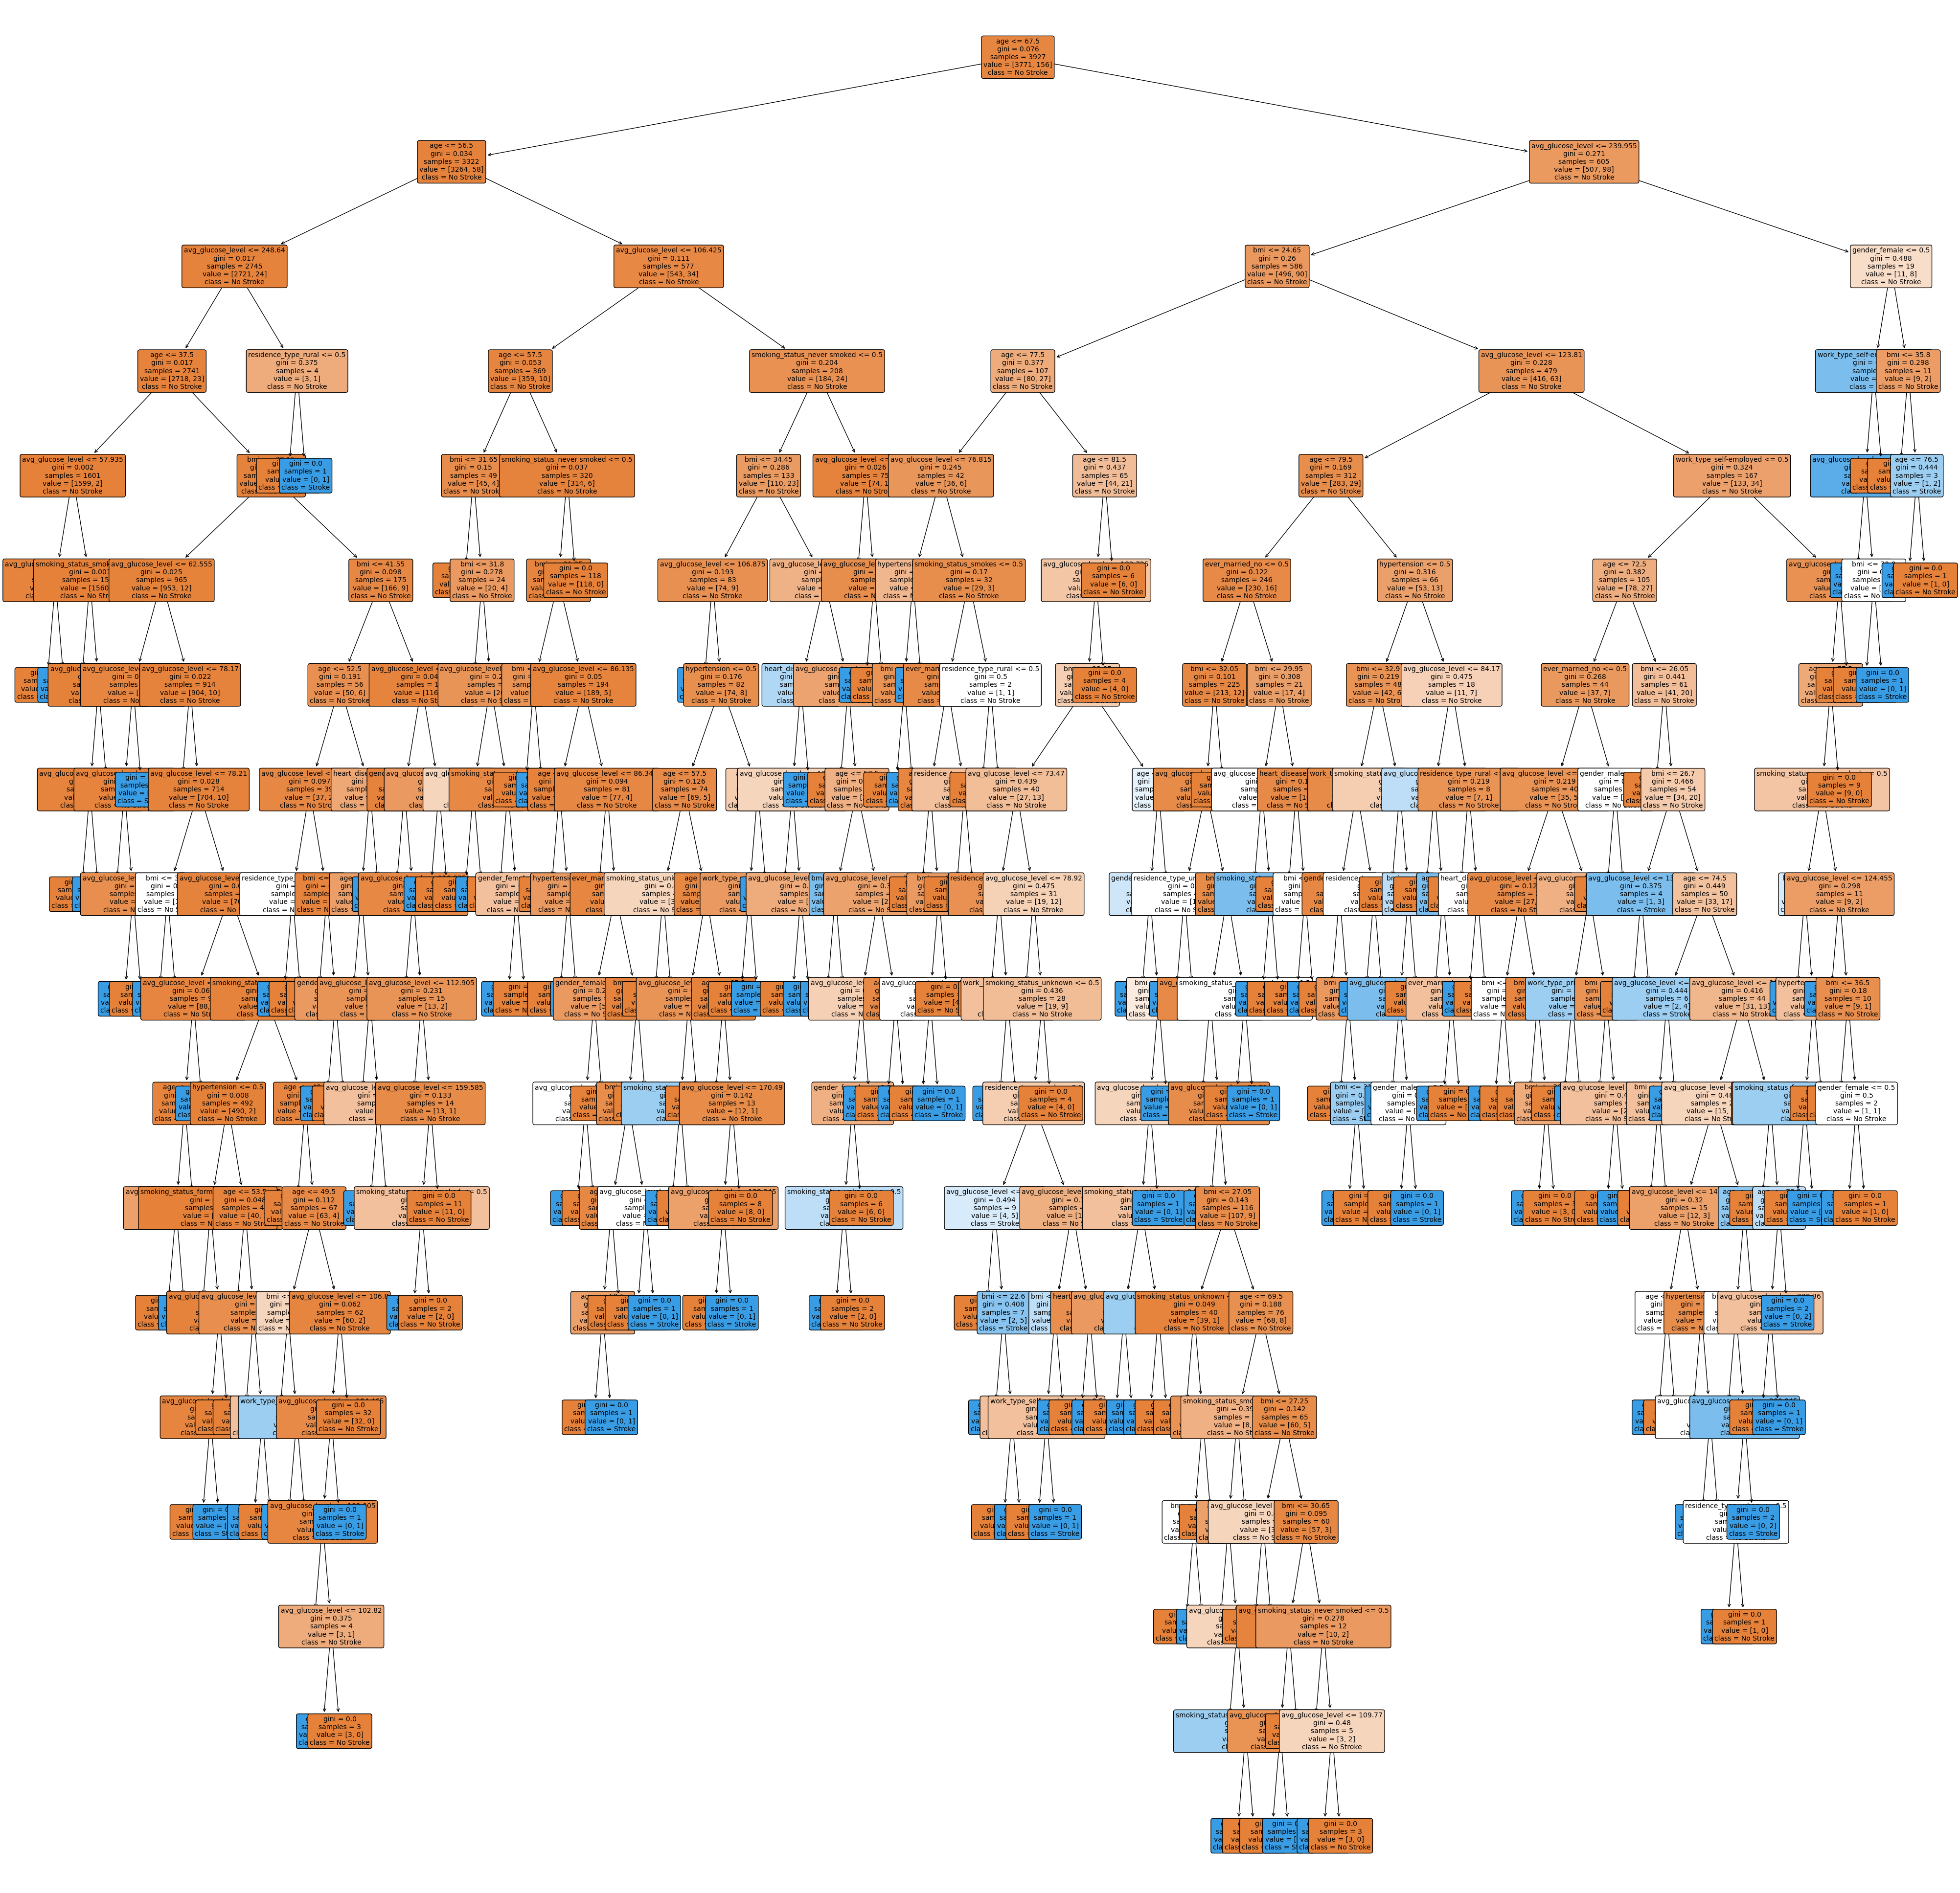

In [19]:
from sklearn.tree import plot_tree 
# Plot the Decision Tree
pt.figure(figsize = (50,50))
plot_tree(dt, filled = True, feature_names = x_train.columns, class_names = ['No Stroke','Stroke'], rounded = True, fontsize = 10)
pt.show()

### Bernoulli Naive Bayes 
#### Initial Model

Accuracy: 93.99%
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       929
           1       0.12      0.02      0.03        53

    accuracy                           0.94       982
   macro avg       0.54      0.51      0.50       982
weighted avg       0.90      0.94      0.92       982



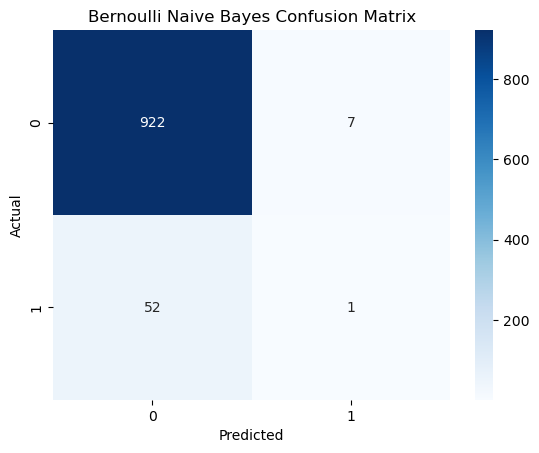

In [38]:
# Bernoulli Model 
bnb = BernoulliNB()

# Train model
bnb.fit(x_train, y_train)

# Predictions 
bnb_predict = bnb.predict(x_test)

# Accuracy of Bernoulli Naive Bayes Model & Additional Metrics 
accuracy = accuracy_score(y_test, bnb_predict)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification Report Bernoulli Naive Bayes
classification_report_bnb = classification_report(y_test, bnb_predict)
print("Classification Report:\n", classification_report_bnb)

# Oversampled Bernoulli Naive Bayes Confusion Matrix 
bnb_matrix = confusion_matrix(t_y_test, bnb_predict)
sb.heatmap(bnb_matrix, annot = True, fmt = 'd', cmap = 'Blues')
pt.xlabel('Predicted')
pt.ylabel('Actual')
pt.title('Bernoulli Naive Bayes Confusion Matrix')
pt.show()

Again with the Bernoulli model, the accuracy of the model is high but struggles to predict stroke patients in the initial model. The confusion matrix shows that 922 non-stroke patients were correctly identified, and only one stroke patient correctly predicted. 

#### Refined Model With Oversampling & Reducded Variables

Accuracy: 86.15%
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92       929
           1       0.18      0.45      0.26        53

    accuracy                           0.86       982
   macro avg       0.57      0.67      0.59       982
weighted avg       0.92      0.86      0.89       982



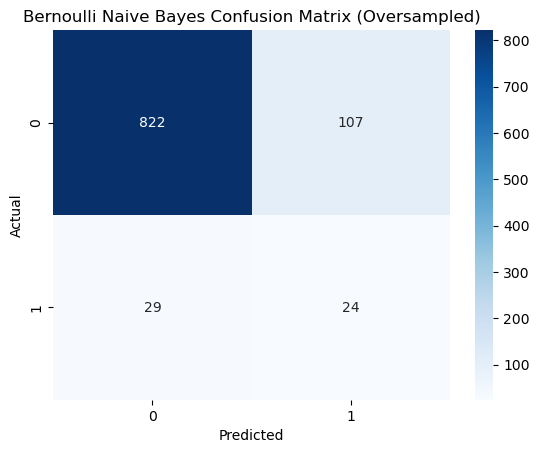

In [39]:
col_drop = ['gender_female', 'gender_male', 'gender_other', 'ever_married_yes', 'ever_married_no',
            'work_type_children', 'work_type_govt_job', 'work_type_never_worked', 'work_type_private',
            'work_type_self-employed', 'residence_type_rural', 'residence_type_urban',
            'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes',
            'smoking_status_unknown']

bnb_x_train = x_train_resample.drop(columns=col_drop, axis=1)
bnb_x_test = x_test.drop(columns=col_drop, axis=1)
bnb_y_train = y_train_resample
bnb_y_test = y_test

# Bernoulli Model
bnb_os = BernoulliNB()

# Train model
bnb_os.fit(bnb_x_train, bnb_y_train)

# Predictions
bnb_predict_os = bnb_os.predict(bnb_x_test)

# Accuracy of Bernoulli Naive Bayes Model & Additional Metrics
accuracy_os = accuracy_score(bnb_y_test, bnb_predict_os)
print(f"Accuracy: {accuracy_os * 100:.2f}%")

# Classification Report Bernoulli Naive Bayes
classification_report_bnb_os = classification_report(bnb_y_test, bnb_predict_os)
print("Classification Report:\n", classification_report_bnb_os)

# Oversampled Bernoulli Naive Bayes Confusion Matrix 
bnb_matrix_os = confusion_matrix(bnb_y_test, bnb_predict_os)
sb.heatmap(bnb_matrix_os, annot = True, fmt = 'd', cmap = 'Blues')
pt.xlabel('Predicted')
pt.ylabel('Actual')
pt.title('Bernoulli Naive Bayes Confusion Matrix (Oversampled)')
pt.show()

Oversampling the Bernoulli model leads to similar results of the other refined models, decrease to accuracy but stroke prediction tends to get more accurate. This time the Bernoulli oversampled model correctly identifies 822 non-stroke patients (decrease from initial model) with an increase of correctly identified stroke patients. 

### Suport Vector Machine Models 

In [24]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC

col_drop = ['gender_female','gender_male','gender_other','ever_married_yes','ever_married_no',
            'work_type_children','work_type_govt_job','work_type_never_worked','work_type_private',
            'work_type_self-employed','residence_type_rural','residence_type_urban','smoking_status_formerly smoked',
            'smoking_status_never smoked','smoking_status_smokes','smoking_status_unknown']

svm_x_train = x_train_resample.drop(columns = col_drop, axis = 1)
svm_x_test = x_test.drop(columns = col_drop, axis = 1)
svm_y_train = y_train_resample 
svm_y_test = y_test

# Function to run grid search and run the best model 
def find_best_model(model, param_grid, x_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    best_parameters = grid_search.best_params_
    
    return best_model, best_parameters 

# Linear SVM Model 
l_svm = make_pipeline(StandardScaler(), SVC(kernel='linear'))
param_grid_l_svm = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100]}
best_l_svm, best_parameters_l_svm = find_best_model(l_svm, param_grid_l_svm, svm_x_train, svm_y_train)

# Radial Basis Function
rbf_svm = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
param_grid_rbf_svm = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100]}
best_rbf_svm, best_parameters_rbf_svm = find_best_model(rbf_svm, param_grid_rbf_svm, svm_x_train, svm_y_train)

# Polynomial 
p_svm = make_pipeline(StandardScaler(), SVC(kernel='poly'))
param_grid_p_svm = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100]}
best_p_svm, best_parameters_p_svm = find_best_model(p_svm, param_grid_p_svm, svm_x_train, svm_y_train)

# Fit models with best parameters
best_l_svm.fit(svm_x_train, svm_y_train)
best_rbf_svm.fit(svm_x_train, svm_y_train)
best_p_svm.fit(svm_x_train, svm_y_train)

# Make predictions
l_svm_predict = best_l_svm.predict(svm_x_test)
rbf_svm_predict = best_rbf_svm.predict(svm_x_test)
p_svm_predict = best_p_svm.predict(svm_x_test)

# Accuracy of SVM Models & additional Metrics 
l_svm_accuracy = accuracy_score(svm_y_test, l_svm_predict)
l_svm_classification_report = classification_report(svm_y_test, l_svm_predict)
l_svm_matrix = confusion_matrix(svm_y_test, l_svm_predict)

rbf_svm_accuracy = accuracy_score(svm_y_test, rbf_svm_predict)
rbf_svm_classification_report = classification_report(svm_y_test, rbf_svm_predict)
rbf_svm_matrix = confusion_matrix(svm_y_test, rbf_svm_predict)

p_svm_accuracy = accuracy_score(svm_y_test, p_svm_predict)
p_svm_classification_report = classification_report(svm_y_test, p_svm_predict)
p_svm_matrix = confusion_matrix(svm_y_test, p_svm_predict)

# Print the evaluation metrics
print(f"Linear SVM Accuracy: {l_svm_accuracy * 100:.2f}%")
print("Linear SVM Classification Report:\n", l_svm_classification_report)
print("Linear SVM Confusion Matrix:\n", l_svm_matrix)
print("Best Linear SVM Parameters:", best_parameters_l_svm)

print(f"Radial Basis Function SVM Accuracy: {rbf_svm_accuracy * 100:.2f}%")
print("Radial Basis Function Classification Report:\n", rbf_svm_classification_report)
print("Radial Basis Function Confusion Matrix:\n", rbf_svm_matrix)
print("Best Radial Basis Function SVM Parameters:", best_parameters_rbf_svm)

print(f"Polynomial SVM Accuracy: {p_svm_accuracy * 100:.2f}%")
print("Polynomial SVM Classification Report:\n", p_svm_classification_report)
print("Polynomial SVM Confusion Matrix:\n", p_svm_matrix)
print("Best Polynomial SVM Parameters:", best_parameters_p_svm)

Linear SVM Accuracy: 71.79%
Linear SVM Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.72      0.83       929
           1       0.11      0.60      0.19        53

    accuracy                           0.72       982
   macro avg       0.54      0.66      0.51       982
weighted avg       0.92      0.72      0.79       982

Linear SVM Confusion Matrix:
 [[673 256]
 [ 21  32]]
Best Linear SVM Parameters: {'svc__C': 0.01}
Radial Basis Function SVM Accuracy: 75.05%
Radial Basis Function Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.77      0.85       929
           1       0.10      0.43      0.16        53

    accuracy                           0.75       982
   macro avg       0.53      0.60      0.51       982
weighted avg       0.91      0.75      0.82       982

Radial Basis Function Confusion Matrix:
 [[714 215]
 [ 30  23]]
Best Radial Basis Function SVM P

To finish the classification modeling portion we finish with three Support Vector Machine (SVM) models, linear, radial basis, and polynomial. All three of the models compare similar to logisitc regression, decision tree, random forests, and Bernoulli models, struggling on accurate prediction of stroke. ALl three models are in 70's% for accuracy prediction but predict more stroke patients than almost every other model. 

## Conclusion 

Through this project we have explored the patient data, created classification models, refined those models, and for each model attempted to predict stroke patients. The major challenge throughout this project was the imbalance of stroke patients, these records made up less than five percent of the sample population. We've gone through and applied multiple ways to refine these models, oversampling the minority class (stroke = 1), undersampling the majority class (stroke = 0), cross-validation, expanding test size, grid search, and the removal of categorical variables.

Additional data would be beneficial to improve these models, understanding patient's initial symptoms could be leveraged to predict their status. The model performance could be improved with more stroke patients, these patients made up only a small percentage of the sample data, understanding the trends of stroke patients could provide more of a story. 

The final logisitic regression model was able to identify the most stroke patients, but this was only after trimmming the variables down to significantly with a 73.5% accuracy and increasing the test size were we able to imporve the model. However, the tradeoffs of falsely prediciting a stroke or nonstroke patient could have life and death implications.

In [25]:
warnings.resetwarnings()